In [1]:
!pip install shap


   ---------------------------------------- 0.0/531.1 kB ? eta -:--:--
   ---------------------------------------- 531.1/531.1 kB 8.7 MB/s eta 0:00:00


In [2]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix


In [4]:
# Read the file as plain text to get the actual column names
with open("./data/subject-info.csv", "r", encoding="utf-8") as f:
    first_line = f.readline().strip()

# Extract column names (unaltered from the CSV)
true_columns = first_line.split(";")

# Search for duplicate column names
seen = {}
new_column_names = []

for col in true_columns:
    if col in seen:
        seen[col] += 1
        new_column_names.append(f"{col}_{seen[col]}")  # Assign unique names
    else:
        seen[col] = 1
        new_column_names.append(col)

# Reload DataFrame with corrected column names
df_final = pd.read_csv("./data/subject-info.csv", sep=";", encoding="utf-8", names=new_column_names, skiprows=1)

# Check if "Average RR (ms)" was correctly renamed
rr_columns_final = [col for col in df_final.columns if "Average RR" in col or "Average_RR" in col]

# Display results
df_final[rr_columns_final].head()


Average RR (ms)   Average RR (ms)
0              1111            984.0
1              1176            682.0
2               588            667.0
3               896            845.0
4               896            811.0

In [5]:
# Manually rename duplicate columns "Average RR (ms)"
rename_dict = {
    rr_columns_final[0]: "Average_RR_ms_1",
    rr_columns_final[1]: "Average_RR_ms_2"
}

# Rename columns in the DataFrame
df_final = df_final.rename(columns=rename_dict)

# Final verification of column names
df_final[["Average_RR_ms_1", "Average_RR_ms_2"]].head()


Average_RR_ms_1  Average_RR_ms_2
0             1111            984.0
1             1176            682.0
2              588            667.0
3              896            845.0
4              896            811.0

In [6]:
df_final.head()


Patient ID  Follow-up period from enrollment (days)  days_4years  \
0      P0001                                     2065         1460   
1      P0002                                     2045         1460   
2      P0003                                     2044         1460   
3      P0004                                     2044         1460   
4      P0005                                     2043         1460   

   Exit of the study  Cause of death Age  Gender (male=1)  Weight (kg)  \
0                NaN               0  58                1           83   
1                NaN               0  58                1           74   
2                NaN               0  69                1           83   
3                NaN               0  56                0           84   
4                NaN               0  70                1           97   

   Height (cm) Body Mass Index (Kg/m2)  ...  \
0          163                    31,2  ...   
1          160                    28,9  ...   
2          174                    27,4  ...   
3          165                    30,9  ...   
4          183                      29  ...   

   Angiotensin-II receptor blocker (yes=1)  \
0                                        0   
1                                        1   
2                                        1   
3                                        1   
4                                        0   

   Anticoagulants/antitrombotics  (yes=1)  Betablockers (yes=1)  \
0                                       1                     1   
1                                       1                     1   
2                                       1                     1   
3                                       1                     1   
4                                       1                     1   

   Digoxin (yes=1)  Loop diuretics (yes=1)  Spironolactone (yes=1)  \
0                1                       1                       0   
1                0                       0                       0   
2                1                       1                       0   
3                0                       1                       1   
4                0                       1                       0   

   Statins (yes=1)  Hidralazina (yes=1)  ACE inhibitor (yes=1)  \
0                0                    0                      1   
1                1                    0                      0   
2                0                    0                      0   
3                0                    0                      0   
4                1                    0                      1   

   Nitrovasodilator (yes=1)  
0                         0  
1                         0  
2                         0  
3                         0  
4                         1  

[5 rows x 103 columns]

In [7]:
cleaned_csv_path = "./data/subject-info_cleaned_2_final.csv"

df_final.to_csv(cleaned_csv_path, sep=";", encoding="utf-8", index=False)

print(f"File successfully saved: {cleaned_csv_path}")


File successfully saved: ./data/subject-info_cleaned_2_final.csv


In [8]:
import pandas as pd

df = pd.read_csv("./data/subject-info_cleaned_2_final.csv", sep=";", encoding="utf-8")
df.head()

Patient ID  Follow-up period from enrollment (days)  days_4years  \
0      P0001                                     2065         1460   
1      P0002                                     2045         1460   
2      P0003                                     2044         1460   
3      P0004                                     2044         1460   
4      P0005                                     2043         1460   

   Exit of the study  Cause of death Age  Gender (male=1)  Weight (kg)  \
0                NaN               0  58                1           83   
1                NaN               0  58                1           74   
2                NaN               0  69                1           83   
3                NaN               0  56                0           84   
4                NaN               0  70                1           97   

   Height (cm) Body Mass Index (Kg/m2)  ...  \
0          163                    31,2  ...   
1          160                    28,9  ...   
2          174                    27,4  ...   
3          165                    30,9  ...   
4          183                      29  ...   

   Angiotensin-II receptor blocker (yes=1)  \
0                                        0   
1                                        1   
2                                        1   
3                                        1   
4                                        0   

   Anticoagulants/antitrombotics  (yes=1)  Betablockers (yes=1)  \
0                                       1                     1   
1                                       1                     1   
2                                       1                     1   
3                                       1                     1   
4                                       1                     1   

   Digoxin (yes=1)  Loop diuretics (yes=1)  Spironolactone (yes=1)  \
0                1                       1                       0   
1                0                       0                       0   
2                1                       1                       0   
3                0                       1                       1   
4                0                       1                       0   

   Statins (yes=1)  Hidralazina (yes=1)  ACE inhibitor (yes=1)  \
0                0                    0                      1   
1                1                    0                      0   
2                0                    0                      0   
3                0                    0                      0   
4                1                    0                      1   

   Nitrovasodilator (yes=1)  
0                         0  
1                         0  
2                         0  
3                         0  
4                         1  

[5 rows x 103 columns]

In [9]:
def clean_data(df):
    print("\n Starting data cleaning...")

    #  1. Remove duplicate column names if present
    df = df.loc[:, ~df.columns.duplicated()].copy()

    #  2. If 'Average_RR_ms' contains two columns, split them correctly
    if "Average_RR_ms" in df.columns:
        if isinstance(df["Average_RR_ms"], pd.DataFrame):
            df["Average_RR_1_ms"] = df["Average_RR_ms"].iloc[:, 0]
            df["Average_RR_2_ms"] = df["Average_RR_ms"].iloc[:, 1]
            df.drop(columns=["Average_RR_ms"], inplace=True)
            print(" 'Average_RR_ms' successfully split into two columns!")

    #  3. Identify problematic numeric columns
    problematic_columns = df.select_dtypes(include=['object']).columns.tolist()

    #  4. Remove non-numeric columns from conversion list
    exclude_columns = ["Patient_ID", "Holter_onset_hhmmss"]
    convertible_columns = [col for col in problematic_columns if col not in exclude_columns]

    #  5. Replace commas with dots and convert only true numeric values
    for col in convertible_columns:
        if df[col].dtype == "object":  # Ensure the column contains strings
            try:
                df[col] = df[col].astype(str)  # Convert to string
                df[col] = df[col].str.replace(",", ".", regex=True)  # Replace commas with dots
                df[col] = df[col].str.replace(r"[^0-9.]", "", regex=True)  # Remove non-numeric characters except dots
                df[col] = pd.to_numeric(df[col], errors="coerce")  # Convert to float, set errors to NaN
                print(f" Column {col} successfully converted.")
            except ValueError:
                print(f" Column {col} could not be converted and remains in its original format.")
        else:
            print(f"ℹ Column {col} is already numeric and will be skipped.")

    print(f" Successfully converted columns: {convertible_columns}")
    print(f" Non-converted columns (contained text): {exclude_columns}")

    #  6. Handle missing values
    missing_values = df.isnull().sum()
    high_missing = missing_values[missing_values > 0.3 * len(df)].index.tolist()
    if high_missing:
        print(f" Removing columns with >30% missing values: {high_missing}")
        df.drop(columns=high_missing, inplace=True)
    else:
        print(" No columns with excessive missing values.")

    df.fillna(df.median(numeric_only=True), inplace=True)

    #  7. Clean column names
    df.columns = (df.columns
        .str.strip()
        .str.replace(r"\s+", "_", regex=True)  # Replace spaces with underscores
        .str.replace(r"[^A-Za-z0-9_]", "", regex=True)  # Remove special characters
        .str.replace(r"_+", "_", regex=True)  # Replace multiple underscores with a single one
    )

    print(" Column names cleaned!")

    print("\n Data cleaning completed!")
    return df

#  Retrieve cleaned data
df = clean_data(df)



 Starting data cleaning...
 Column Patient ID successfully converted.
 Column Age successfully converted.
 Column Body Mass Index (Kg/m2) successfully converted.
 Column Albumin (g/L) successfully converted.
 Column Normalized Troponin successfully converted.
 Column Total Cholesterol (mmol/L) successfully converted.
 Column Gamma-glutamil transpeptidase (IU/L) successfully converted.
 Column Glucose (mmol/L) successfully converted.
 Column Hemoglobin (g/L) successfully converted.
 Column HDL (mmol/L) successfully converted.
 Column Potassium (mEq/L) successfully converted.
 Column LDL (mmol/L) successfully converted.
 Column Protein (g/L) successfully converted.
 Column T3 (pg/dL) successfully converted.
 Column T4 (ng/L) successfully converted.
 Column Troponin (ng/mL) successfully converted.
 Column TSH (mIU/L) successfully converted.
 Column Urea (mg/dL) successfully converted.
 Column Cardiothoracic ratio successfully converted.
 Column Holter onset (hh:mm:ss) successfully conver

In [10]:
print("\n **Final Data Structure Check**")

#  1 Number of rows and columns
print(f" **Number of rows:** {df.shape[0]}")
print(f" **Number of columns:** {df.shape[1]}")

#  2 Check data types
print("\n **Data types after cleaning:**")
print(df.dtypes.value_counts())

#  3 Check for missing values
missing_values = df.isnull().sum()
missing_values_sorted = missing_values[missing_values > 0].sort_values(ascending=False)
print("\n **Missing values after cleaning:**")
print(missing_values_sorted if not missing_values_sorted.empty else " No missing values!")

#  4 Display the first few rows of the DataFrame
print("\n **First 5 rows of the cleaned data:**")
print(df.head())

#  5 Check if categorical variables are still present
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
print("\n **Categorical columns in the DataFrame:**")
print(categorical_columns if categorical_columns else " No categorical columns left!")



 **Final Data Structure Check**
 **Number of rows:** 992
 **Number of columns:** 94

 **Data types after cleaning:**
int64      51
float64    43
Name: count, dtype: int64

 **Missing values after cleaning:**
 No missing values!

 **First 5 rows of the cleaned data:**
   Patient_ID  Followup_period_from_enrollment_days  days_4years  \
0           1                                  2065         1460   
1           2                                  2045         1460   
2           3                                  2044         1460   
3           4                                  2044         1460   
4           5                                  2043         1460   

   Cause_of_death  Age  Gender_male1  Weight_kg  Height_cm  \
0               0   58             1         83        163   
1               0   58             1         74        160   
2               0   69             1         83        174   
3               0   56             0         84        165   
4           

EDA

In [11]:
print(df.head())
print(df.info())
print(df.shape)
print(df.dtypes)
print(df.describe())


   Patient_ID  Followup_period_from_enrollment_days  days_4years  \
0           1                                  2065         1460   
1           2                                  2045         1460   
2           3                                  2044         1460   
3           4                                  2044         1460   
4           5                                  2043         1460   

   Cause_of_death  Age  Gender_male1  Weight_kg  Height_cm  \
0               0   58             1         83        163   
1               0   58             1         74        160   
2               0   69             1         83        174   
3               0   56             0         84        165   
4               0   70             1         97        183   

   Body_Mass_Index_Kgm2  NYHA_class  ...  AngiotensinII_receptor_blocker_yes1  \
0                  31.2           3  ...                                    0   
1                  28.9           2  ...                

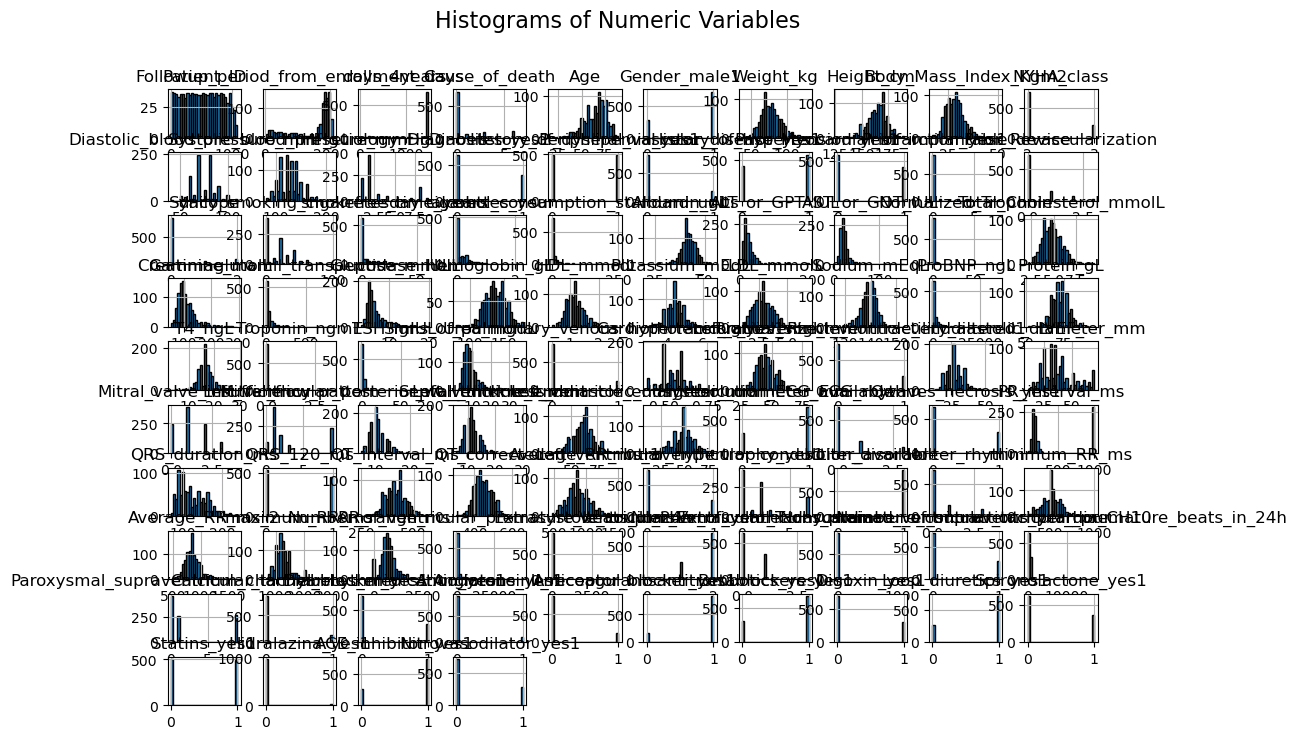

In [13]:
# Histograms for all numeric columns
df.hist(figsize=(12,8), bins=30, edgecolor='black')
plt.suptitle("Histograms of Numeric Variables", fontsize=16)
plt.show()


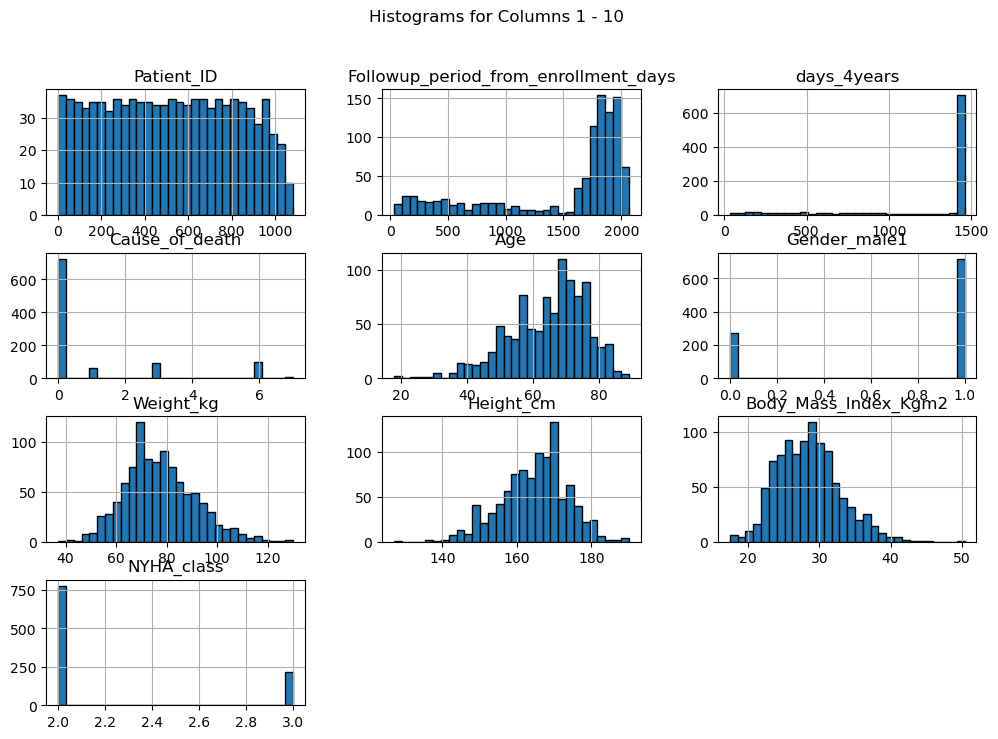

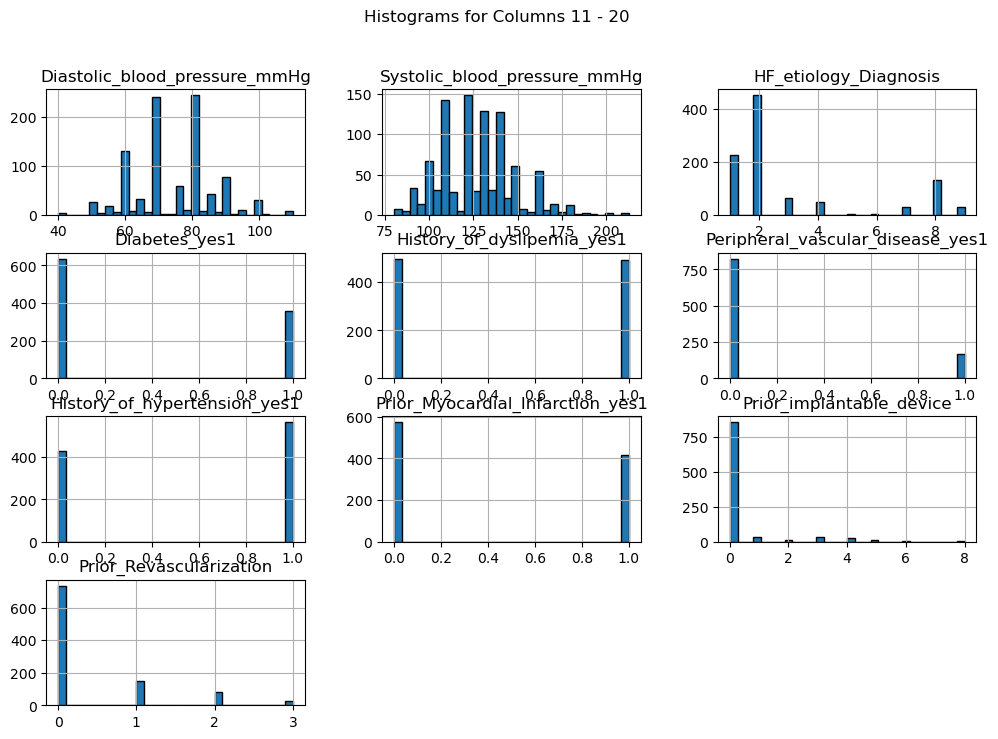

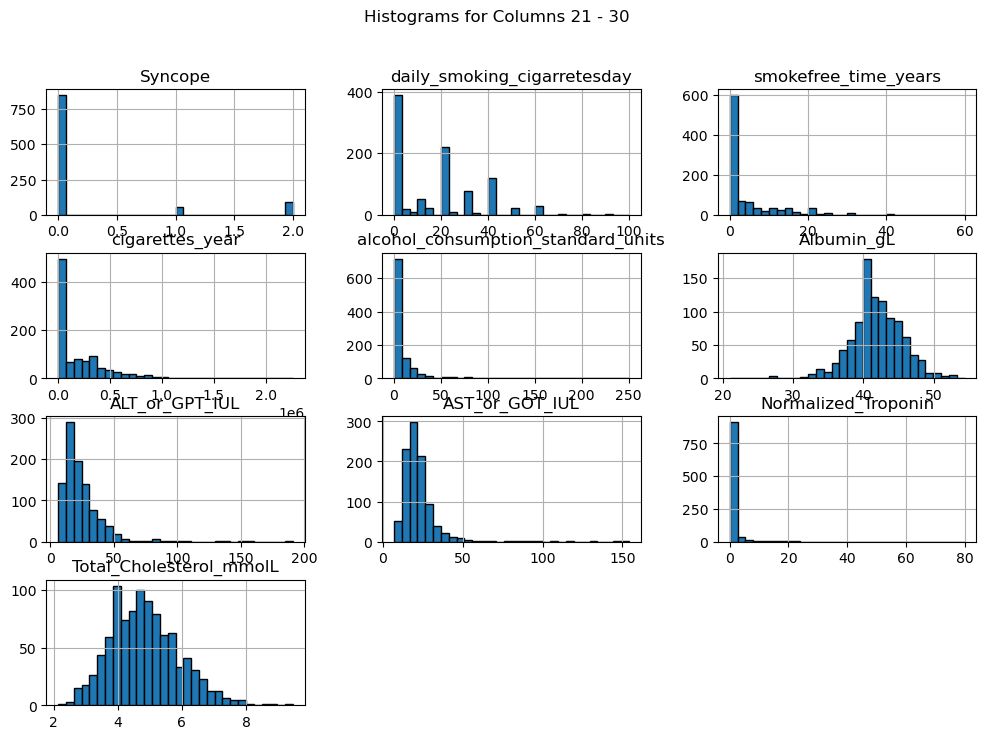

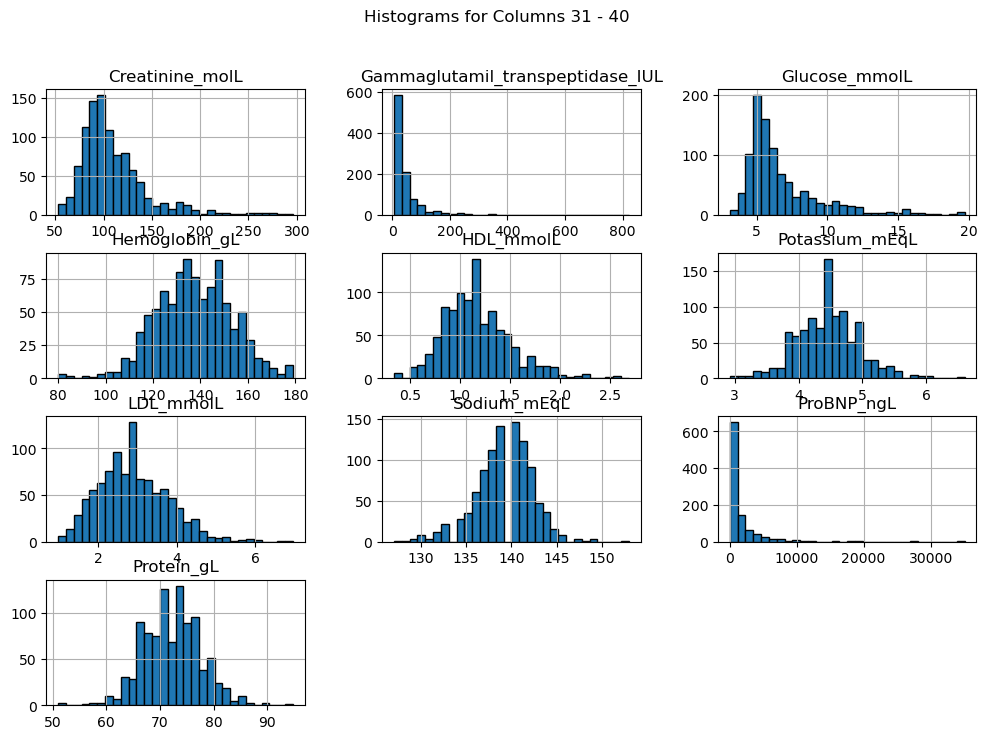

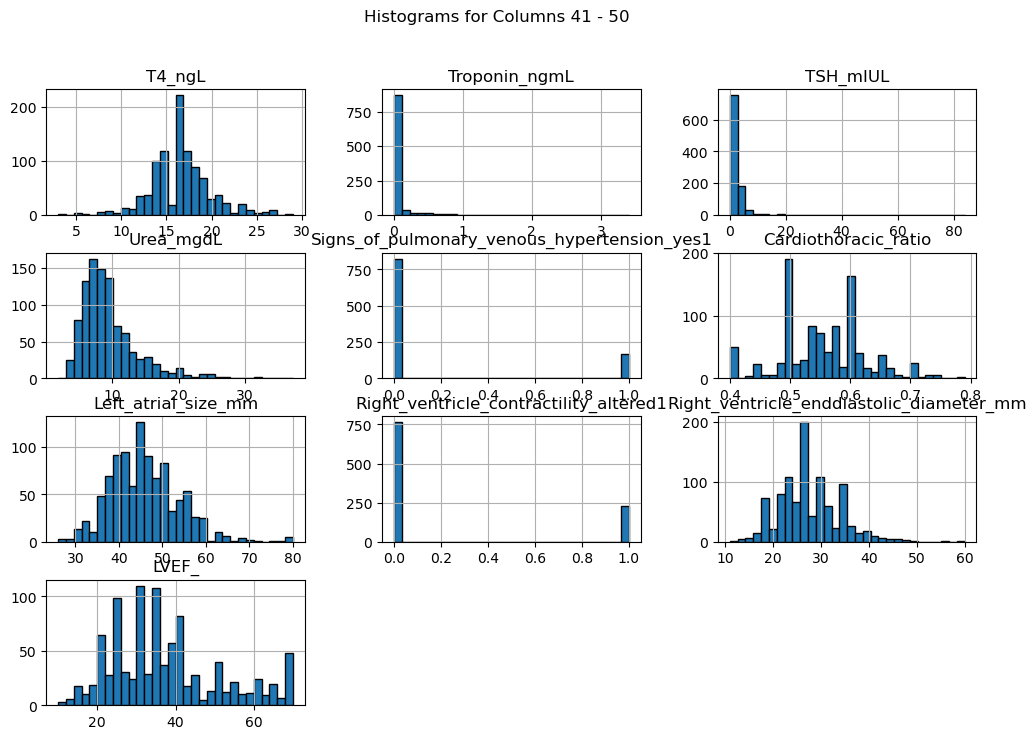

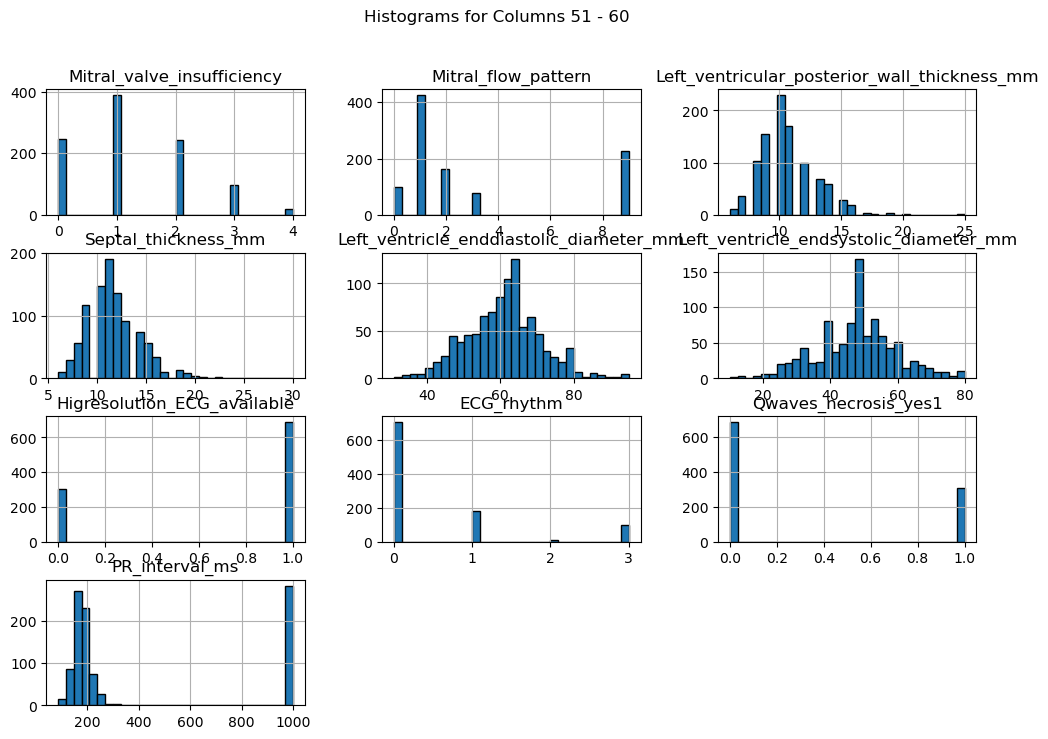

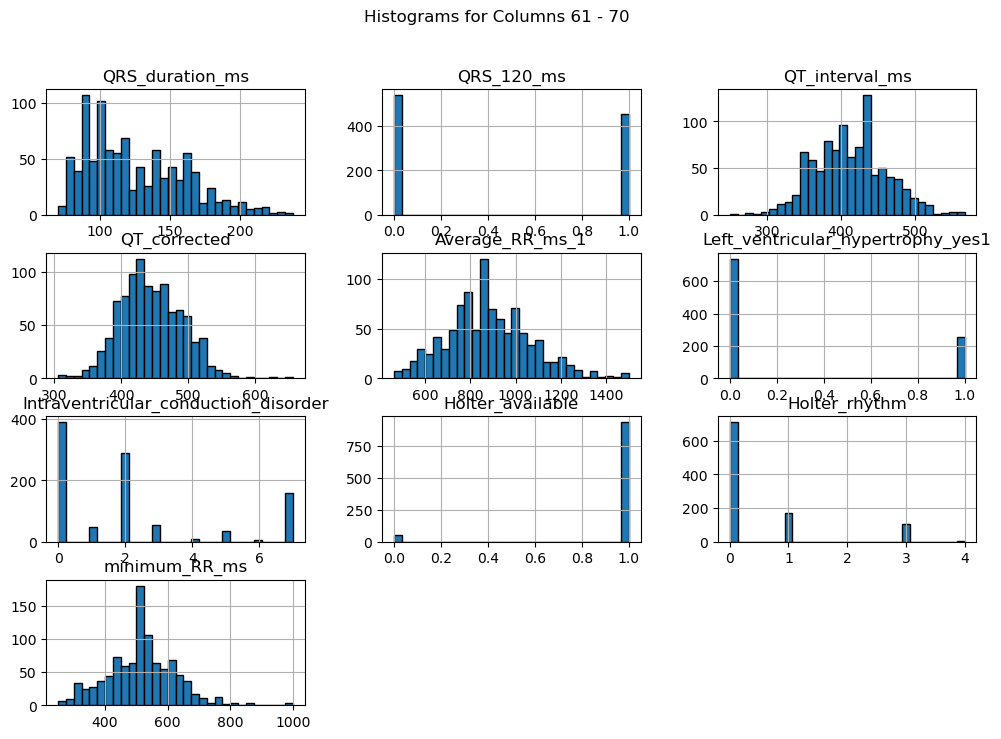

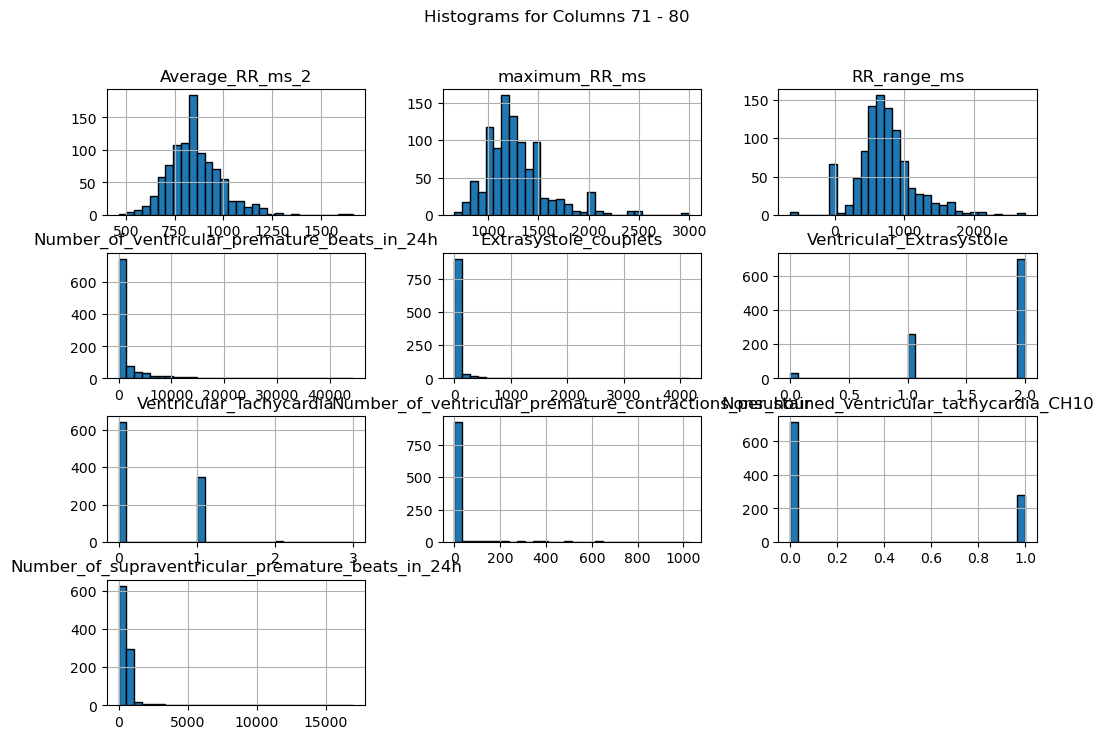

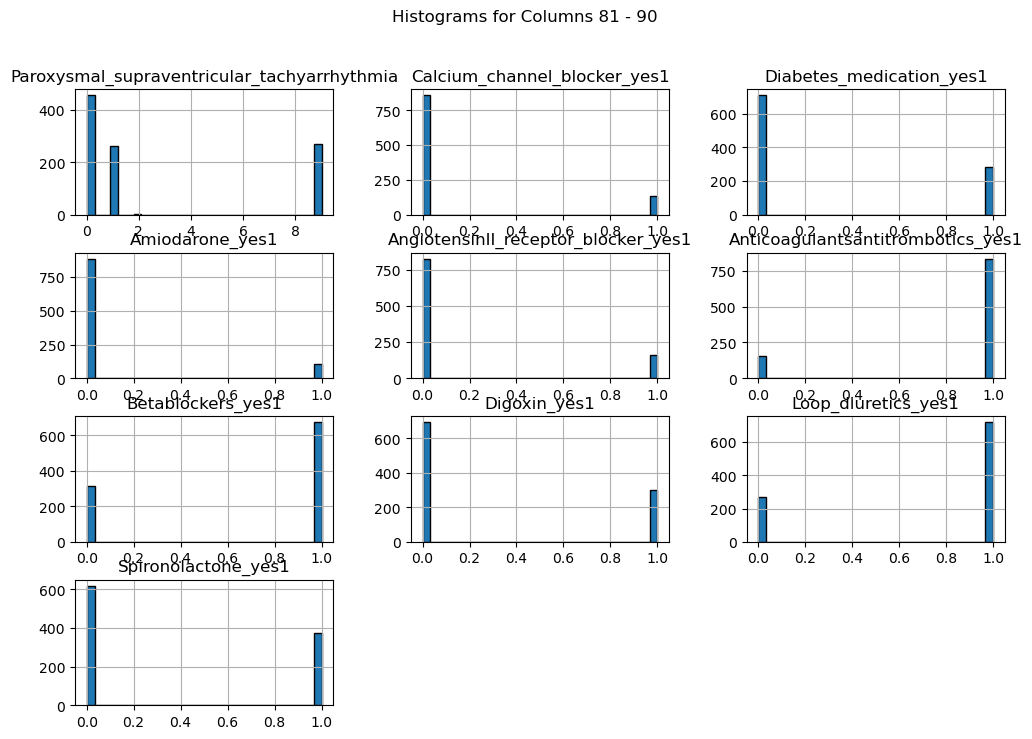

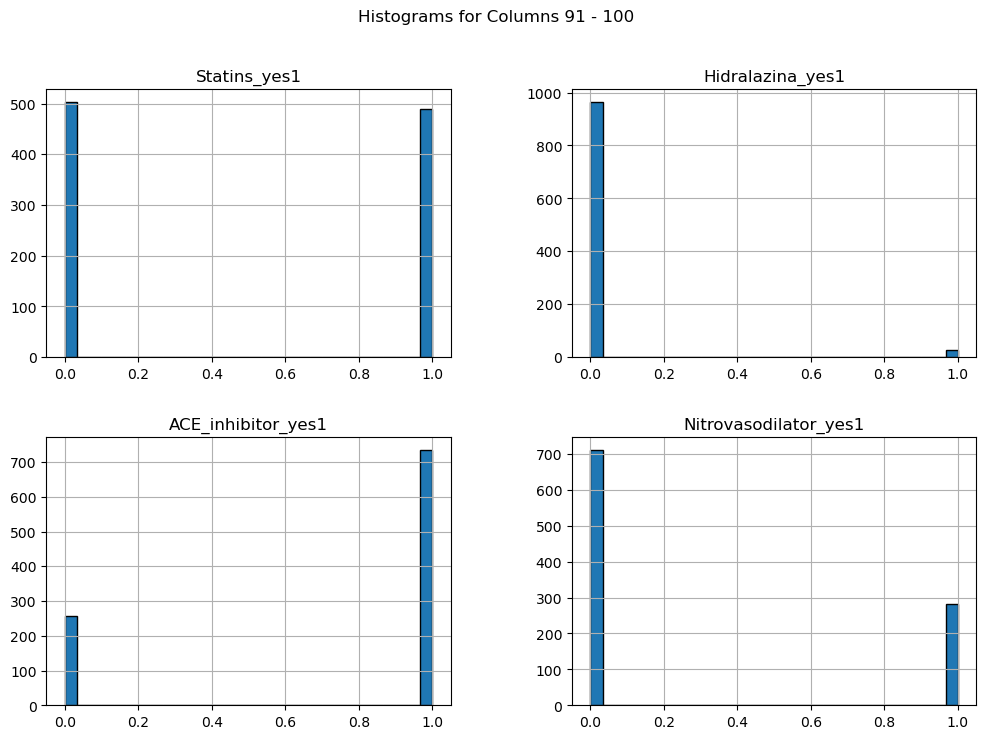

In [14]:
# Display histograms in groups
num_features = df.select_dtypes(include=["float64", "int64"]).columns

# Split the variables into groups of 10
for i in range(0, len(num_features), 10):
    subset = num_features[i:i+10]
    df[subset].hist(figsize=(12, 8), bins=30, edgecolor='black')
    plt.suptitle(f"Histograms for Columns {i+1} - {i+10}")
    plt.show()


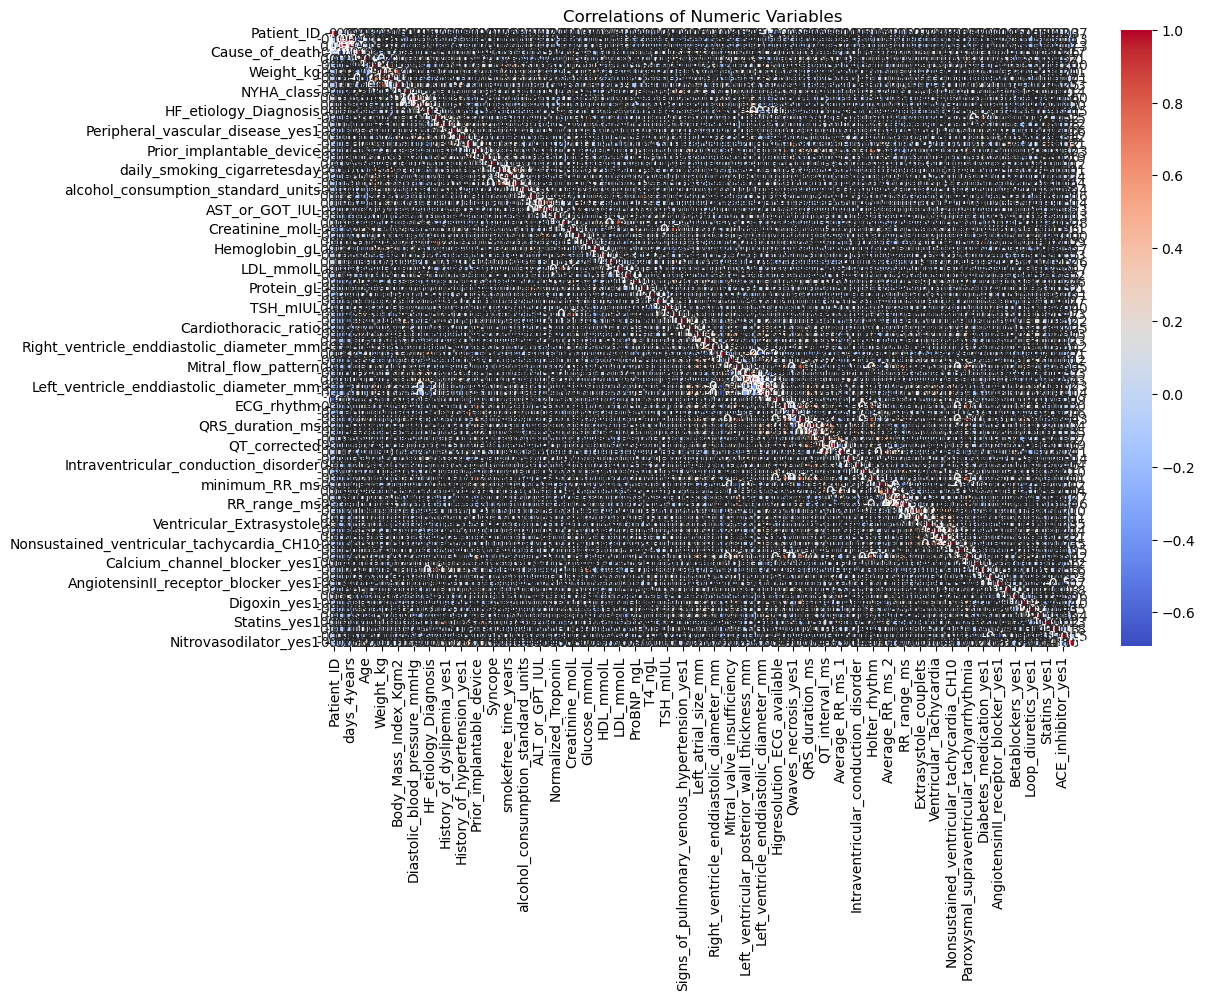

In [15]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlations of Numeric Variables")
plt.show()


In [12]:
# Calculate the correlations and sort them in descending order
correlation_matrix = df.corr()
correlation_target = correlation_matrix["Cause_of_death"].sort_values(ascending=False)  # target variable

print("Top 10 positively correlated variables:")
print(correlation_target.head(10))

print("\nTop 10 negatively correlated variables:")
print(correlation_target.tail(10))


Top 10 positively correlated variables:
Cause_of_death                            1.000000
Urea_mgdL                                 0.244389
Creatinine_molL                           0.239282
Left_atrial_size_mm                       0.223836
NYHA_class                                0.203841
ProBNP_ngL                                0.186795
Age                                       0.184975
Nitrovasodilator_yes1                     0.165931
Right_ventricle_contractility_altered1    0.147750
Peripheral_vascular_disease_yes1          0.147628
Name: Cause_of_death, dtype: float64

Top 10 negatively correlated variables:
Body_Mass_Index_Kgm2                   -0.089239
Average_RR_ms_1                        -0.095003
Sodium_mEqL                            -0.099411
Hemoglobin_gL                          -0.101961
LVEF_                                  -0.107505
Weight_kg                              -0.117290
Albumin_gL                             -0.129437
Betablockers_yes1            

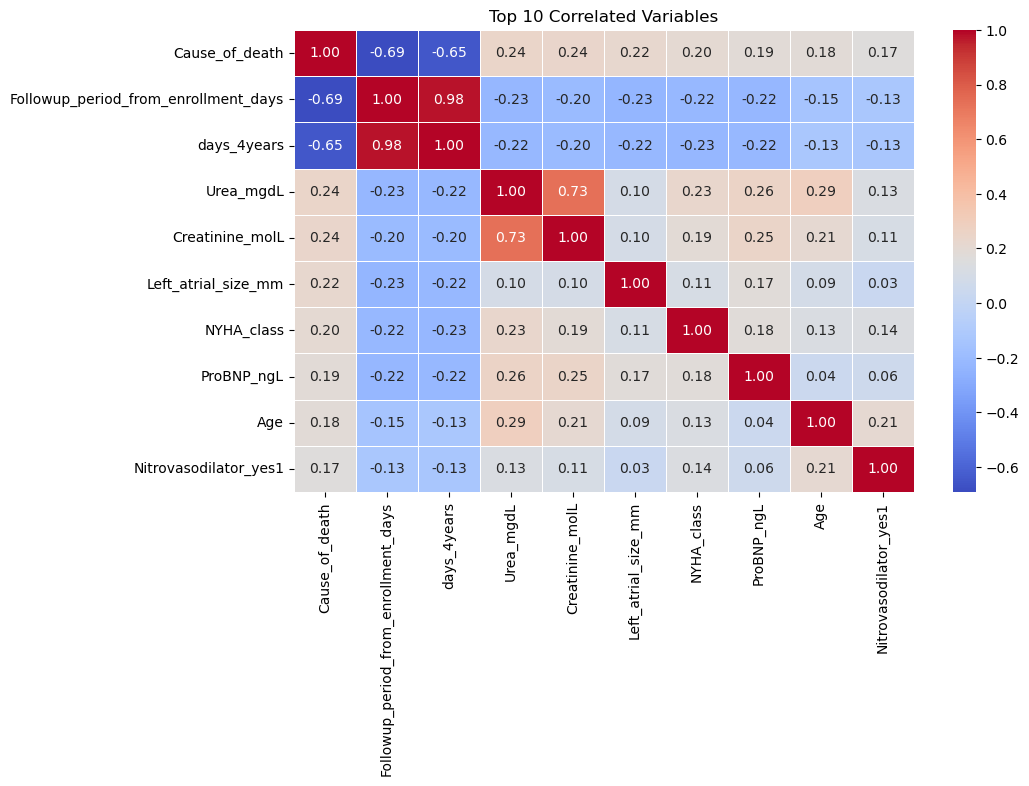

In [39]:
# Select the 10 most important features based on their correlation with the target variable
top_features = correlation_target.abs().sort_values(ascending=False).head(10).index

# Create a reduced correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(df[top_features].corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Top 10 Correlated Variables")
plt.show()


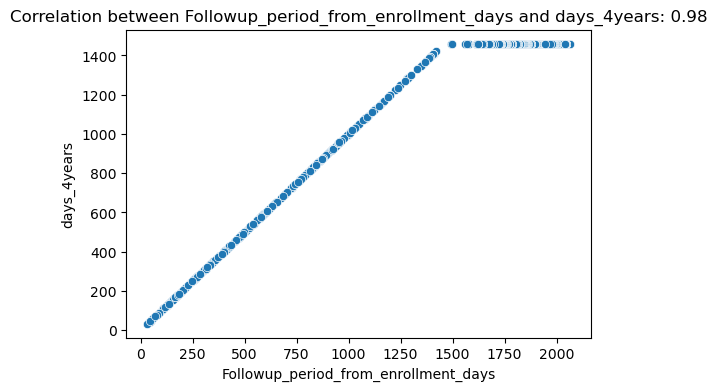

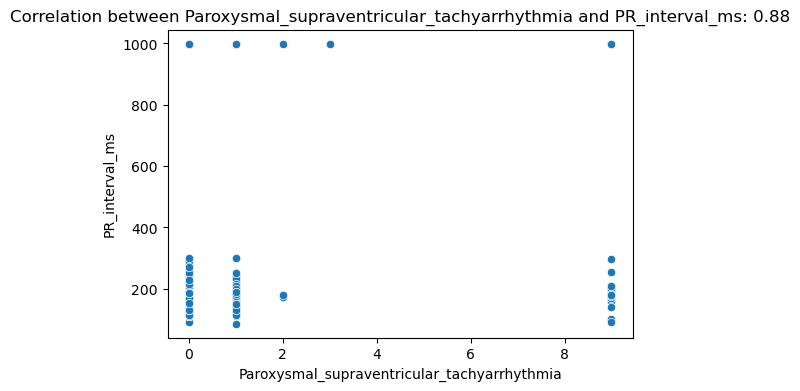

In [40]:
# Select the two most strongly correlated variables
top_corr_pairs = correlation_matrix.unstack().sort_values(ascending=False)
top_corr_pairs = top_corr_pairs[top_corr_pairs < 1].drop_duplicates().head(2)  # Avoid 1-correlation

for var1, var2 in top_corr_pairs.index:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=df[var1], y=df[var2])
    plt.title(f"Correlation between {var1} and {var2}: {top_corr_pairs[var1, var2]:.2f}")
    plt.show()


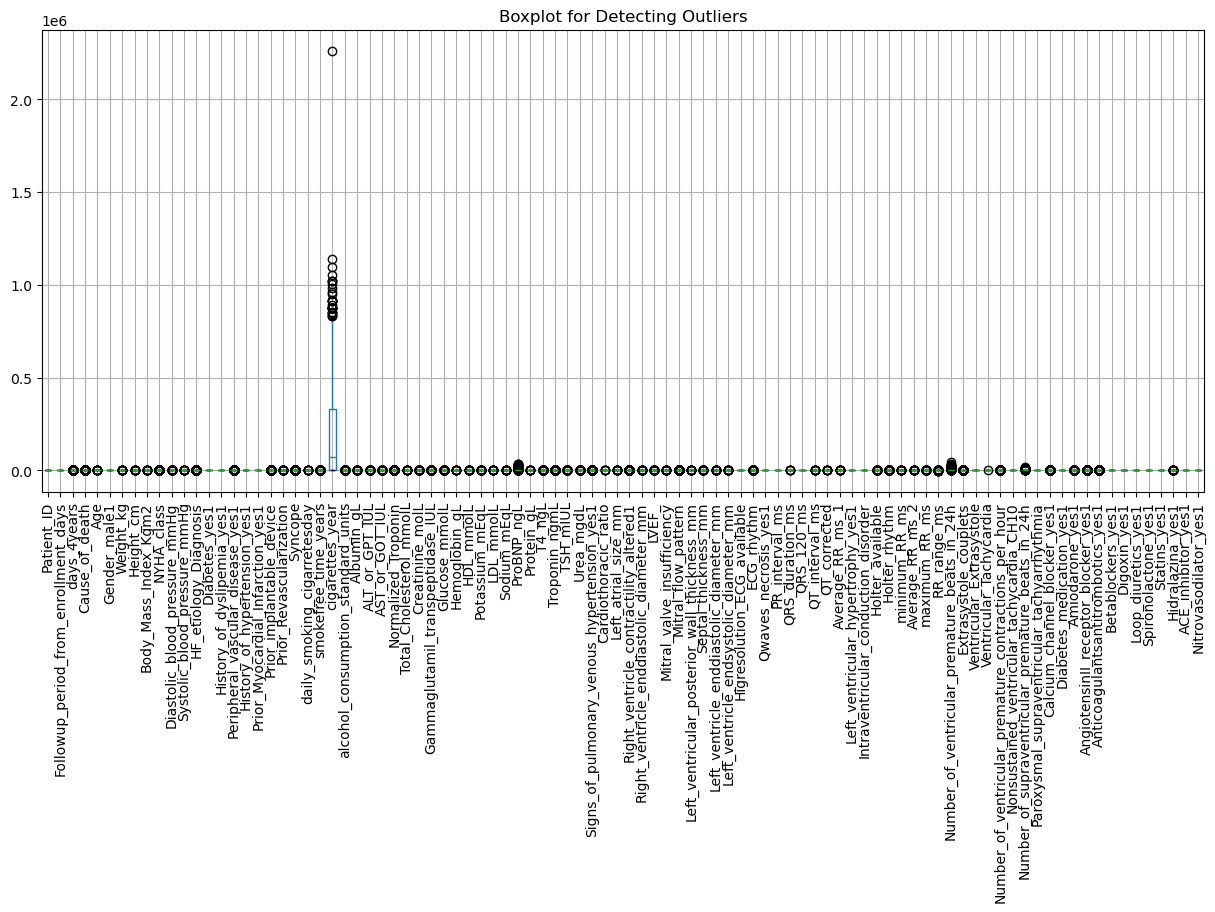

In [19]:
plt.figure(figsize=(15, 6))
df.boxplot(rot=90)  # Rotates axis labels for better readability
plt.title("Boxplot for Detecting Outliers")
plt.show()


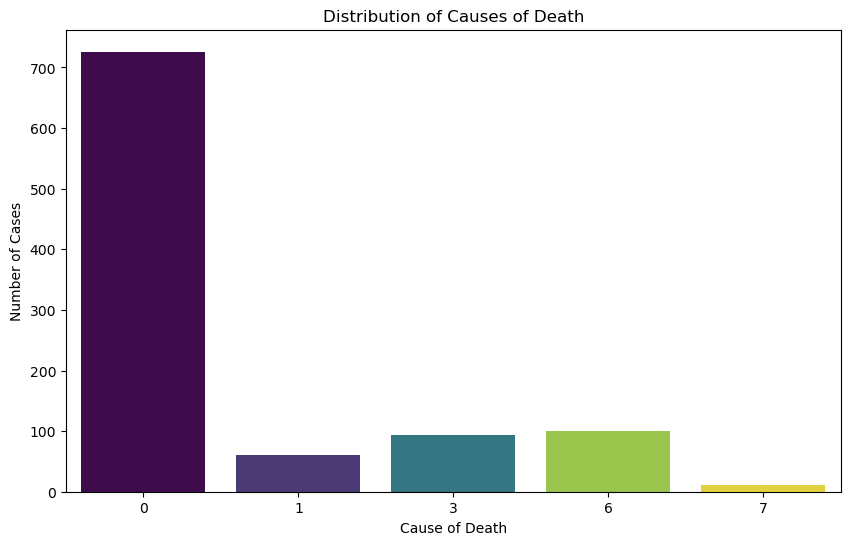

In [20]:
plt.figure(figsize=(10,6))
sns.countplot(x="Cause_of_death", data=df, hue="Cause_of_death", palette="viridis", legend=False)
plt.title("Distribution of Causes of Death")
plt.xlabel("Cause of Death")
plt.ylabel("Number of Cases")
plt.show()


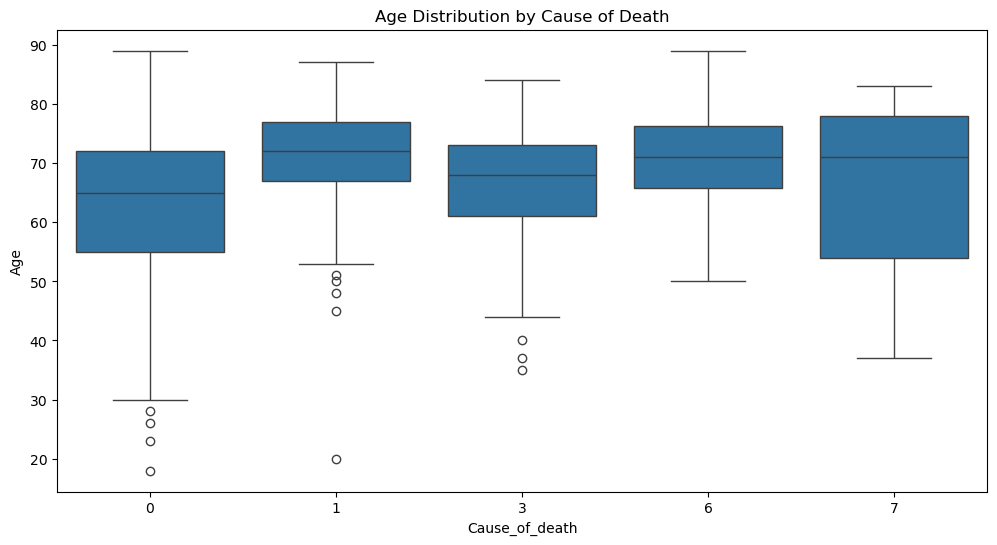

In [21]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="Cause_of_death", y="Age", data=df)
plt.title("Age Distribution by Cause of Death")
plt.show()


Maschine Learning 

In [13]:
# 🔹 1 Ensure that all possible values are included in the mapping
cause_mapping = {
    0: 0,  # Survivor
    1: 1,  # Non-Cardiac Death
    3: 2,  # Sudden Cardiac Death (SCD)
    6: 3,  # Pump Failure Death
    7: 3   # Pump Failure Death (same category as 6)
}

# 🔹 2 Apply the mapping correctly (BEFORE the split!)
df["Cause_of_death"] = df["Cause_of_death"].map(cause_mapping)

# 🔹 3 If NaN values appear, replace them with a default category
df["Cause_of_death"] = df["Cause_of_death"].fillna(-1)  # If unknown values exist

# 🔹 4 Ensure that all values are mapped correctly
print("Unique values after mapping:", df["Cause_of_death"].unique())

# 🔹 5 Perform Train/Test Split (NOW with the correct target variable)
X = df.drop(columns=["Cause_of_death"])
y = df["Cause_of_death"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 🔹 6 Check if the values are correctly assigned in y_train and y_test
print("y_train unique values:", y_train.unique())
print("y_test unique values:", y_test.unique())


Unique values after mapping: [0 2 3 1]
y_train unique values: [0 3 2 1]
y_test unique values: [2 0 3 1]


In [14]:
# Fill missing values in numerical columns with the median
for col in df.select_dtypes(include=[np.number]):
    df[col] = df[col].fillna(df[col].median())

# Perform Train/Test Split
X = df.drop(columns=["Cause_of_death"])
y = df["Cause_of_death"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [15]:
# Save train and test data
train_path = "./data/train2.csv"
test_path = "./data/test2.csv"

train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

train_data.to_csv(train_path, sep=";", encoding="utf-8", index=False)
test_data.to_csv(test_path, sep=";", encoding="utf-8", index=False)

# Display results
{
    "Training data saved at": train_path,
    "Test data saved at": test_path,
    "Shape of X_train": X_train.shape,
    "Shape of X_test": X_test.shape,
    "Number of features after encoding": df.shape[1],
}


{'Training data saved at': './data/train2.csv',
 'Test data saved at': './data/test2.csv',
 'Shape of X_train': (793, 93),
 'Shape of X_test': (199, 93),
 'Number of features after encoding': 94}

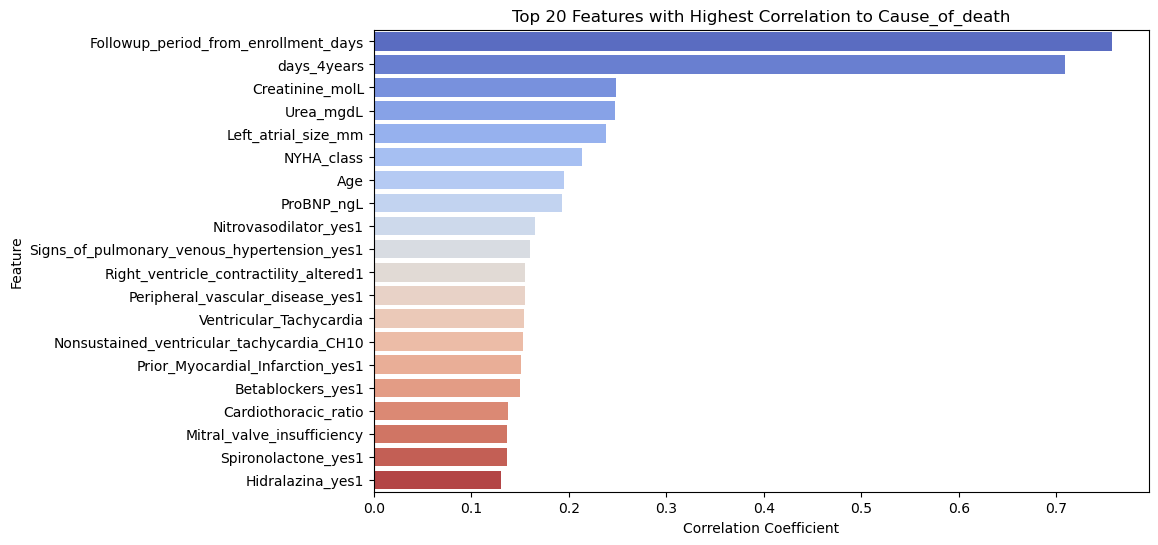

Followup_period_from_enrollment_days           0.756949
days_4years                                    0.709088
Creatinine_molL                                0.248190
Urea_mgdL                                      0.247883
Left_atrial_size_mm                            0.237923
NYHA_class                                     0.213361
Age                                            0.195221
ProBNP_ngL                                     0.192665
Nitrovasodilator_yes1                          0.164999
Signs_of_pulmonary_venous_hypertension_yes1    0.160433
Right_ventricle_contractility_altered1         0.154938
Peripheral_vascular_disease_yes1               0.154637
Ventricular_Tachycardia                        0.153611
Nonsustained_ventricular_tachycardia_CH10      0.152921
Prior_Myocardial_Infarction_yes1               0.151134
Betablockers_yes1                              0.150276
Cardiothoracic_ratio                           0.137275
Mitral_valve_insufficiency                     0

In [16]:
# Calculate correlations with the target variable "Cause_of_death"
corr_matrix = df.corr()
target_corr = corr_matrix["Cause_of_death"].drop("Cause_of_death")

# Display the strongest positive & negative correlations
top_corr_features = target_corr.abs().sort_values(ascending=False).head(20)

# Visualization of the top features
plt.figure(figsize=(10, 6))
sns.barplot(x=top_corr_features.values, y=top_corr_features.index, hue=top_corr_features.index, palette="coolwarm", legend=False)
plt.xlabel("Correlation Coefficient")
plt.ylabel("Feature")
plt.title("Top 20 Features with Highest Correlation to Cause_of_death")
plt.show()

# Display results
top_corr_features


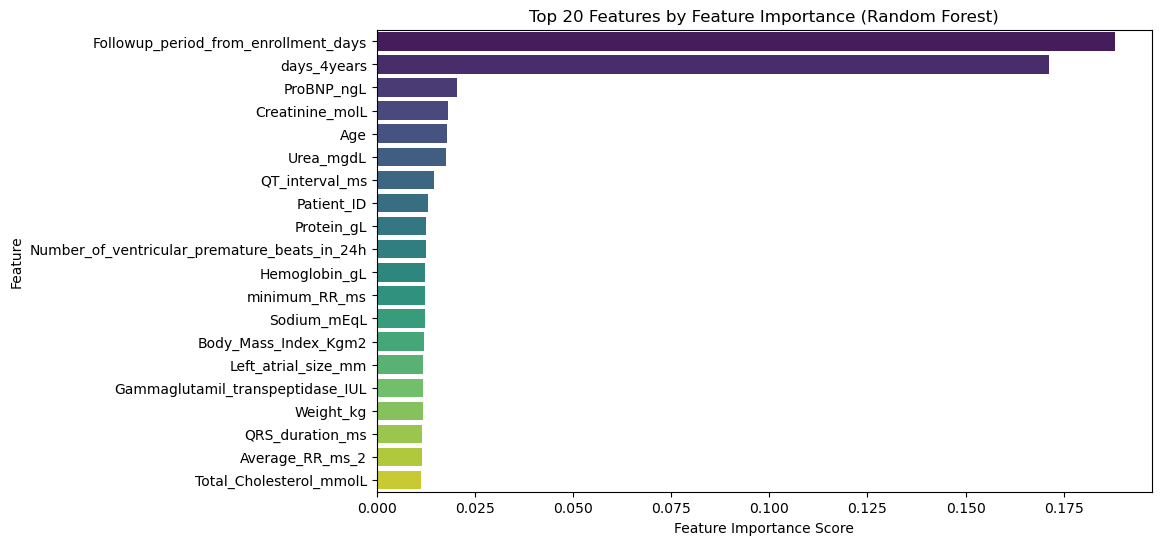

Feature  Importance
1           Followup_period_from_enrollment_days    0.188021
2                                    days_4years    0.171202
37                                    ProBNP_ngL    0.020396
29                               Creatinine_molL    0.018049
3                                            Age    0.017979
42                                     Urea_mgdL    0.017527
61                                QT_interval_ms    0.014675
0                                     Patient_ID    0.013115
38                                    Protein_gL    0.012650
72  Number_of_ventricular_premature_beats_in_24h    0.012537
32                                 Hemoglobin_gL    0.012359
68                                 minimum_RR_ms    0.012345
36                                   Sodium_mEqL    0.012288
7                           Body_Mass_Index_Kgm2    0.011955
45                           Left_atrial_size_mm    0.011872
30              Gammaglutamil_transpeptidase_IUL    0.011867
5                                      Weight_kg    0.011724
59                               QRS_duration_ms    0.011595
69                               Average_RR_ms_2    0.011568
28                       Total_Cholesterol_mmolL    0.011345

In [17]:
# Initialize Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Train model with training data
rf_model.fit(X_train, y_train)

# Calculate feature importances
feature_importances = rf_model.feature_importances_

# Store in DataFrame and sort
feature_importance_df = pd.DataFrame({"Feature": X_train.columns, "Importance": feature_importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False).head(20)

# Visualization of the most important features
plt.figure(figsize=(10, 6))
sns.barplot(
    x=feature_importance_df["Importance"],
    y=feature_importance_df["Feature"],
    hue=feature_importance_df["Feature"],  # Assign feature names to hue
    palette="viridis",
    legend=False  # Disable legend if not needed
)
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.title("Top 20 Features by Feature Importance (Random Forest)")
plt.show()

# Display results
feature_importance_df


In [18]:
# Select the most important features from the feature importance analysis
top_features = feature_importance_df["Feature"].tolist()

# Restrict train and test data to the most important features
X_train_filtered2 = X_train[top_features]
X_test_filtered2 = X_test[top_features]

# Display results
results = {
    "Shape of X_train (filtered)": X_train_filtered2.shape,
    "Shape of X_test (filtered)": X_test_filtered2.shape
}
print(results)

# Combine filtered train and test data with the target variable
train_data_filtered2 = pd.concat([X_train_filtered2, y_train], axis=1)
test_data_filtered2 = pd.concat([X_test_filtered2, y_test], axis=1)

# Save the filtered train and test data
train_path_filtered2 = "./data/train_filtered2.csv"
test_path_filtered2 = "./data/test_filtered2.csv"

train_data_filtered2.to_csv(train_path_filtered2, sep=";", encoding="utf-8", index=False)
test_data_filtered2.to_csv(test_path_filtered2, sep=";", encoding="utf-8", index=False)

# Final output confirmation
output_info = {
    "Training data saved at": train_path_filtered2,
    "Test data saved at": test_path_filtered2,
    "Shape of X_train (filtered)": X_train_filtered2.shape,
    "Shape of X_test (filtered)": X_test_filtered2.shape
}
print(output_info)



{'Shape of X_train (filtered)': (793, 20), 'Shape of X_test (filtered)': (199, 20)}
{'Training data saved at': './data/train_filtered2.csv', 'Test data saved at': './data/test_filtered2.csv', 'Shape of X_train (filtered)': (793, 20), 'Shape of X_test (filtered)': (199, 20)}


 Data successfully prepared!


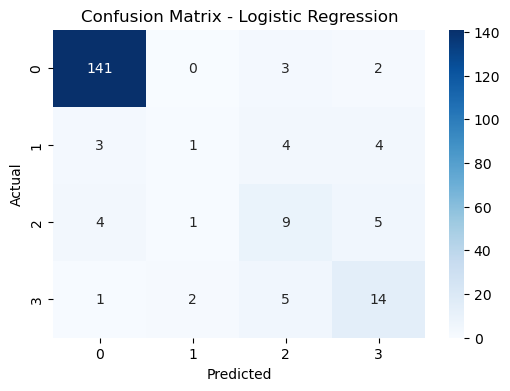

📊 Model: Logistic Regression

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       146
           1       0.25      0.08      0.12        12
           2       0.43      0.47      0.45        19
           3       0.56      0.64      0.60        22

    accuracy                           0.83       199
   macro avg       0.55      0.54      0.53       199
weighted avg       0.81      0.83      0.82       199

--------------------------------------------------


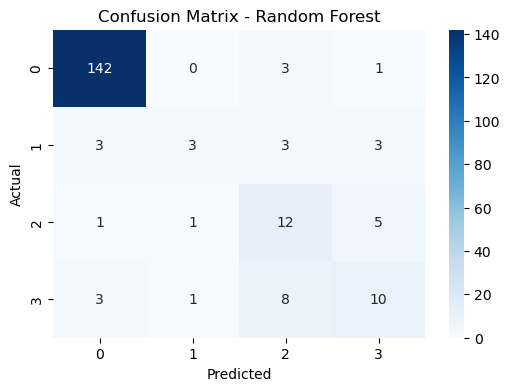

📊 Model: Random Forest

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       146
           1       0.60      0.25      0.35        12
           2       0.46      0.63      0.53        19
           3       0.53      0.45      0.49        22

    accuracy                           0.84       199
   macro avg       0.64      0.58      0.58       199
weighted avg       0.84      0.84      0.83       199

--------------------------------------------------


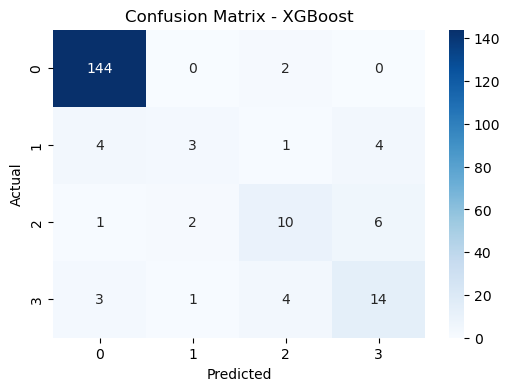

📊 Model: XGBoost

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       146
           1       0.50      0.25      0.33        12
           2       0.59      0.53      0.56        19
           3       0.58      0.64      0.61        22

    accuracy                           0.86       199
   macro avg       0.65      0.60      0.62       199
weighted avg       0.85      0.86      0.85       199

--------------------------------------------------
 Final Model Performance:
{'Logistic Regression': {'Accuracy': 0.8291457286432161, 'F1-Score': 0.8177009280082346}, 'Random Forest': {'Accuracy': 0.8391959798994975, 'F1-Score': 0.8324435526203185}, 'XGBoost': {'Accuracy': 0.8592964824120602, 'F1-Score': 0.8494850806247298}}


In [19]:

y_train_filtered2 = y_train  
y_test_filtered2 = y_test  


print(" Data successfully prepared!")

#  Initialize models
models = {
    "Logistic Regression": LogisticRegression(solver="saga", max_iter=5000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(eval_metric="mlogloss", random_state=42)
}

#  Training and evaluation
results = {}

for model_name, model in models.items():
    # Train model
    model.fit(X_train_filtered2, y_train_filtered2)

    # Make predictions
    y_pred = model.predict(X_test_filtered2)

    # Compute metrics
    accuracy = accuracy_score(y_test_filtered2, y_pred)
    f1 = f1_score(y_test_filtered2, y_pred, average="weighted")

    # Save results
    results[model_name] = {"Accuracy": accuracy, "F1-Score": f1}

    #  Confusion matrix visualization
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_test_filtered2, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    #  Classification report
    print(f"📊 Model: {model_name}\n")
    print(classification_report(y_test_filtered2, y_pred))
    print("-" * 50)

#  Display final results
print(" Final Model Performance:")
print(results)


In [25]:
print(models.keys())


dict_keys(['Logistic Regression', 'Random Forest', 'XGBoost'])


<Figure size 640x480 with 0 Axes>

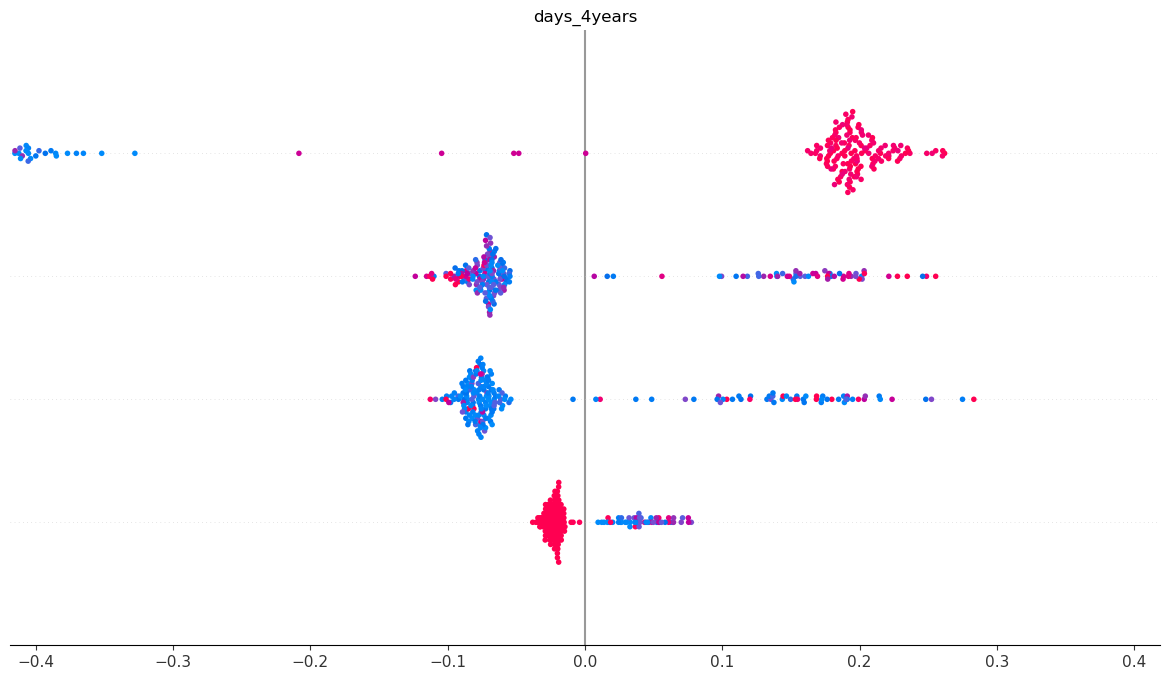

In [26]:
import shap

# Assign the model properly
random_forest_model = models["Random Forest"]

# Initialize SHAP for Random Forest
explainer = shap.TreeExplainer(random_forest_model)
shap_values = explainer.shap_values(X_test_filtered2)

# Plot summary
shap.summary_plot(shap_values, X_test_filtered2)


In [36]:
print(shap_values.shape)
print(X_test_filtered2.shape)


(199, 20, 4)
(199, 20)


In [37]:
for i in range(4):  # Da es 4 Outputs gibt
    print(f"Force plot für Output-Klasse {i}:")
    shap.plots.force(explainer.expected_value[i], shap_values[0, :, i], X_test_filtered2.iloc[0, :])


Force plot für Output-Klasse 0:
Force plot für Output-Klasse 1:
Force plot für Output-Klasse 2:
Force plot für Output-Klasse 3:


In [38]:
import shap
shap.initjs()  # Initialisiert SHAP JS für interaktive Plots

for i in range(4):  # Da es 4 Outputs gibt
    print(f"Force plot für Output-Klasse {i}:")
    display(shap.plots.force(explainer.expected_value[i], shap_values[0, :, i], X_test_filtered2.iloc[0, :]))


Force plot für Output-Klasse 0:


Force plot für Output-Klasse 1:


Force plot für Output-Klasse 2:


Force plot für Output-Klasse 3:


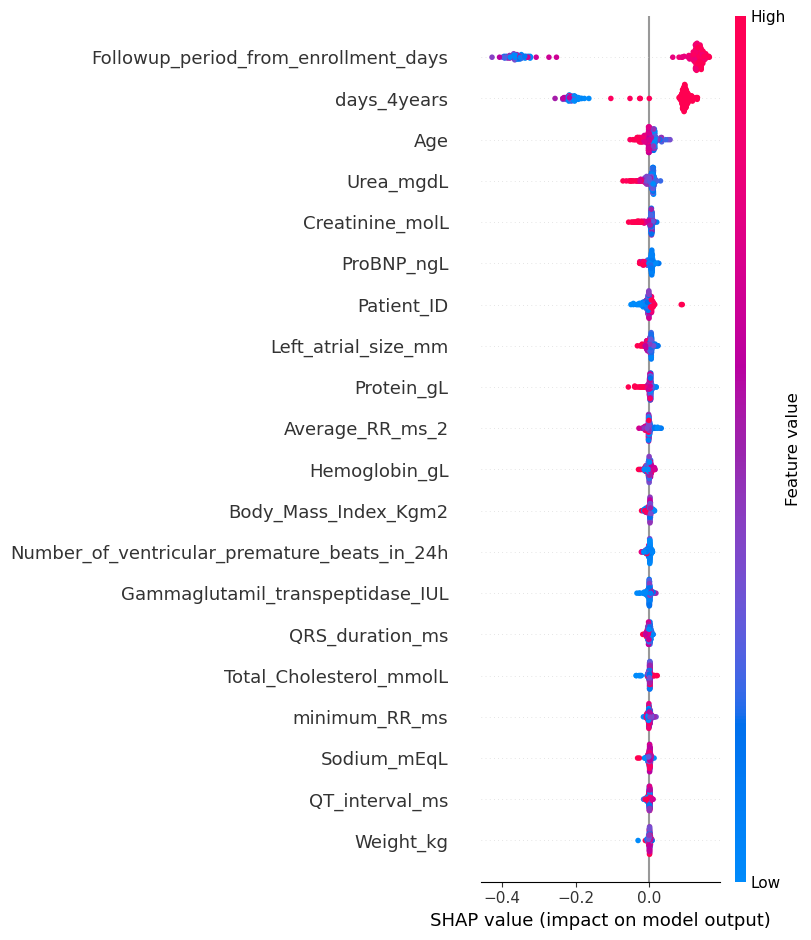

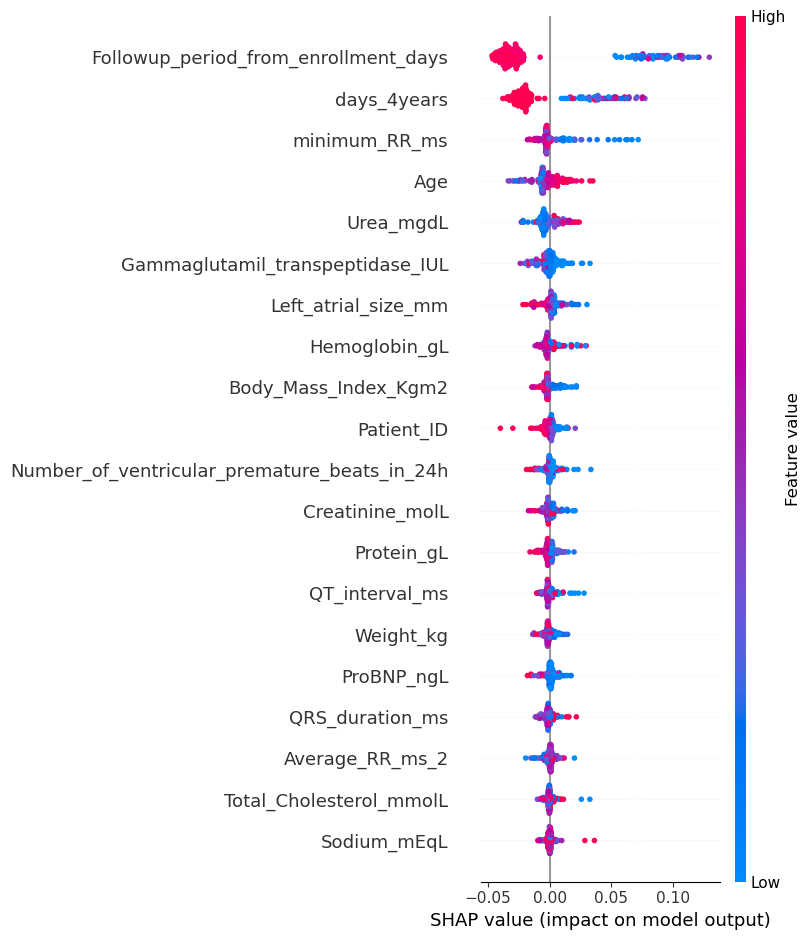

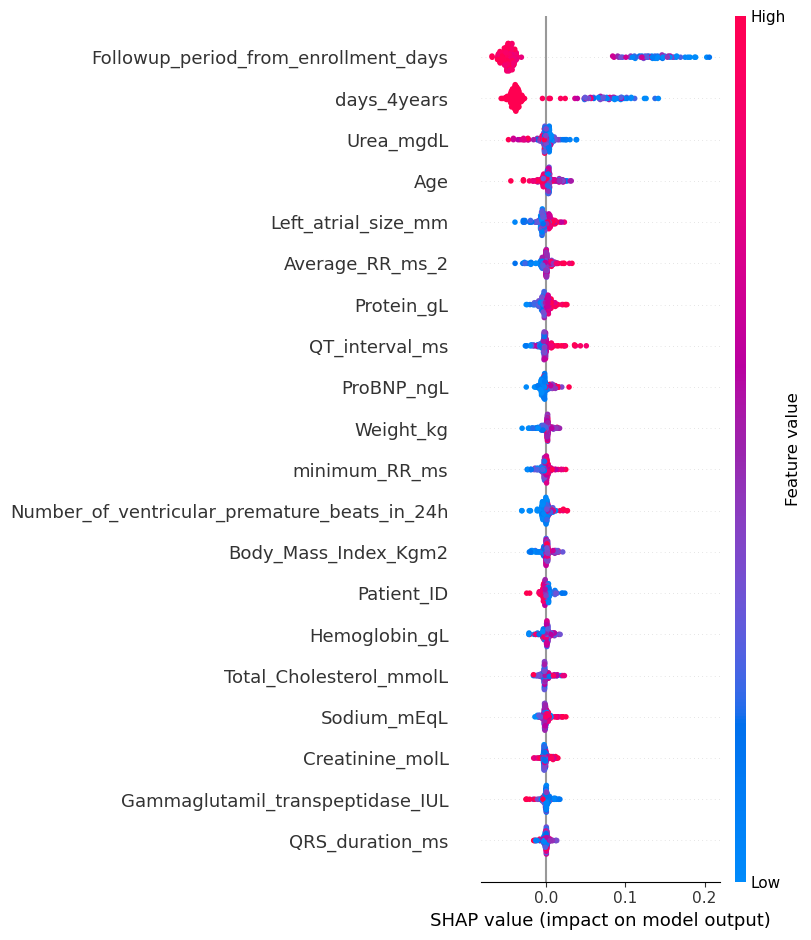

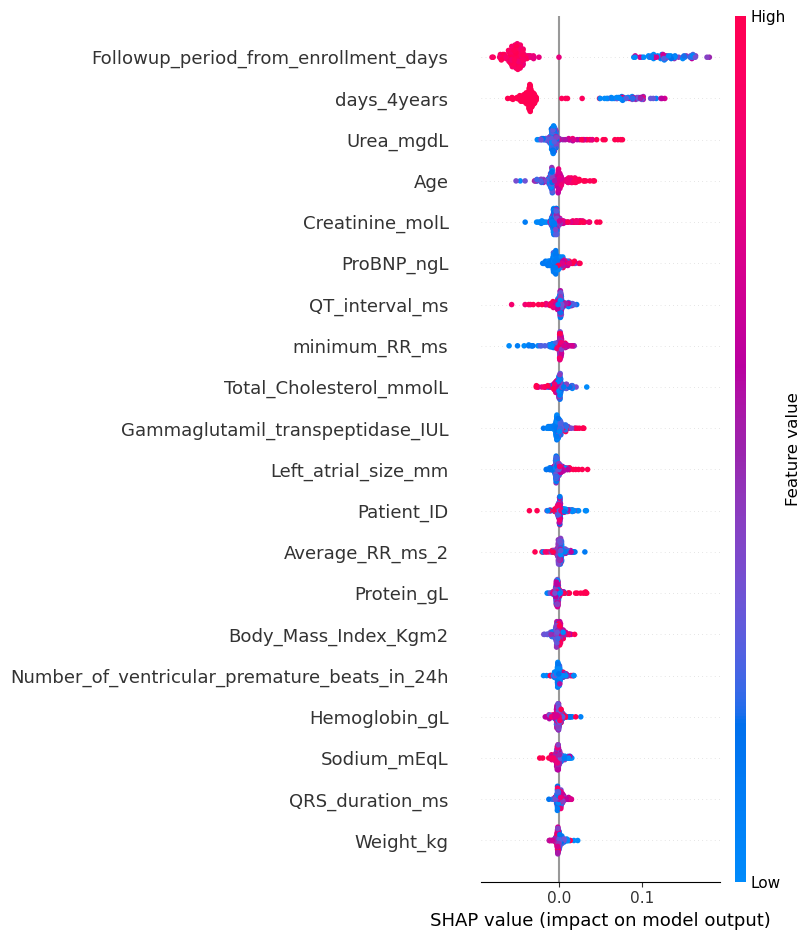

In [39]:
import shap

shap.summary_plot(shap_values[:, :, 0], X_test_filtered2)  # Wichtigste Features für Klasse 0
shap.summary_plot(shap_values[:, :, 1], X_test_filtered2)  # Klasse 1
shap.summary_plot(shap_values[:, :, 2], X_test_filtered2)  # Klasse 2
shap.summary_plot(shap_values[:, :, 3], X_test_filtered2)  # Klasse 3


In [40]:
import numpy as np
import pandas as pd

# Durchschnittliche absolute SHAP-Werte für jede Klasse berechnen
feature_importance = {}

for i in range(4):  # 4 Klassen
    mean_abs_shap = np.abs(shap_values[:, :, i]).mean(axis=0)  # Mittelwert der absoluten SHAP-Werte
    feature_importance[f"Klasse {i}"] = mean_abs_shap

# DataFrame erstellen und sortieren
df_importance = pd.DataFrame(feature_importance, index=X_test_filtered2.columns)
df_importance = df_importance.sort_values(by=df_importance.columns.tolist(), ascending=False)

df_importance


Klasse 0  Klasse 1  Klasse 2  \
Followup_period_from_enrollment_days          0.196397  0.048430  0.073304   
days_4years                                   0.126846  0.028205  0.049204   
Age                                           0.012685  0.007412  0.006188   
Urea_mgdL                                     0.011238  0.006830  0.006512   
Creatinine_molL                               0.008291  0.003197  0.002944   
ProBNP_ngL                                    0.007984  0.002762  0.004941   
Patient_ID                                    0.007823  0.003526  0.003582   
Left_atrial_size_mm                           0.006061  0.004166  0.006099   
Protein_gL                                    0.004779  0.003174  0.005203   
Average_RR_ms_2                               0.004443  0.002216  0.005400   
Hemoglobin_gL                                 0.004208  0.004101  0.003573   
Body_Mass_Index_Kgm2                          0.003911  0.003894  0.003725   
Number_of_ventricular_premature_beats_in_24h  0.003756  0.003387  0.004080   
Gammaglutamil_transpeptidase_IUL              0.003439  0.004763  0.002916   
QRS_duration_ms                               0.003263  0.002698  0.002348   
Total_Cholesterol_mmolL                       0.003093  0.002066  0.003523   
minimum_RR_ms                                 0.002954  0.007960  0.004208   
Sodium_mEqL                                   0.002617  0.001922  0.003052   
QT_interval_ms                                0.002375  0.002889  0.005142   
Weight_kg                                     0.002087  0.002812  0.004276   

                                              Klasse 3  
Followup_period_from_enrollment_days          0.074664  
days_4years                                   0.049606  
Age                                           0.010199  
Urea_mgdL                                     0.011240  
Creatinine_molL                               0.008155  
ProBNP_ngL                                    0.005966  
Patient_ID                                    0.004201  
Left_atrial_size_mm                           0.004388  
Protein_gL                                    0.003788  
Average_RR_ms_2                               0.004161  
Hemoglobin_gL                                 0.003310  
Body_Mass_Index_Kgm2                          0.003703  
Number_of_ventricular_premature_beats_in_24h  0.003315  
Gammaglutamil_transpeptidase_IUL              0.004480  
QRS_duration_ms                               0.002898  
Total_Cholesterol_mmolL                       0.004748  
minimum_RR_ms                                 0.005668  
Sodium_mEqL                                   0.003295  
QT_interval_ms                                0.005727  
Weight_kg                                     0.002676

### **Summary of Feature Importance for Each Class**

#### **Key Findings:**
- **"Followup_period_from_enrollment_days" is the most important feature across all classes.**
  - It has the highest SHAP value for **Class 0 (`0.1964`)** and remains significant for other classes.
  - Time-related features such as `days_4years` are also highly influential.

- **Class-Specific Important Features:**
  - **For Class 0:**
    - `Followup_period_from_enrollment_days` (0.1964)
    - `days_4years` (0.1268)
    - `Age`, `Urea_mgdL`, `Creatinine_molL`
  
  - **For Class 1:**
    - `Followup_period_from_enrollment_days` (0.0484)
    - `days_4years` (0.0282)
    - `Patient_ID`, `Left_atrial_size_mm`
  
  - **For Class 2:**
    - `Followup_period_from_enrollment_days` (0.0733)
    - `days_4years` (0.0492)
    - `Total_Cholesterol_mmolL`, `QT_interval_ms`
  
  - **For Class 3:**
    - `Followup_period_from_enrollment_days` (0.0747)
    - `days_4years` (0.0496)
    - `QT_interval_ms`, `minimum_RR_ms`, `Total_Cholesterol_mmolL`

- **Shared Features Across Classes:**
  - Features such as `Creatinine_molL`, `ProBNP_ngL`, `Patient_ID`, and `Protein_gL` influence all four classes.
  - `Patient_ID` being significant suggests potential **data leakage** and should be further investigated.





In [ ]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grids for each model
param_grids = {
    "Logistic Regression": {
        "solver": ["lbfgs", "saga"],
        "C": [0.1, 1.0, 10],
        "max_iter": [1000, 5000]
    },
    "Random Forest": {
        "n_estimators": [50, 100, 200],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5, 10]
    },
    "XGBoost": {
        "learning_rate": [0.01, 0.1, 0.2],
        "n_estimators": [100, 200, 300],
        "max_depth": [3, 5, 7]
    }
}

# Perform GridSearchCV for each model
optimized_results = {}

for model_name, model in models.items():
    print(f"🔍 Optimizing {model_name}...")
    
    grid_search = GridSearchCV(
        model, param_grids[model_name], cv=5, scoring="accuracy", n_jobs=-1
    )
    
    grid_search.fit(X_train_filtered2, y_train_filtered2)
    
    # Save the best parameters and best score
    optimized_results[model_name] = {
        "Best Params": grid_search.best_params_,
        "Best Score": grid_search.best_score_
    }
    
    print(f" {model_name} optimization completed!")

# Display the optimization results
print("\n Final Hyperparameter Optimization Results:")
for model, result in optimized_results.items():
    print(f"\n{model}:")
    print(f"Best Parameters: {result['Best Params']}")
    print(f"Best Cross-Validation Score: {result['Best Score']:.4f}")


🔍 Optimizing Logistic Regression...
✅ Logistic Regression optimization completed!
🔍 Optimizing Random Forest...
✅ Random Forest optimization completed!
🔍 Optimizing XGBoost...
✅ XGBoost optimization completed!

🎯 Final Hyperparameter Optimization Results:

Logistic Regression:
Best Parameters: {'C': 0.1, 'max_iter': 5000, 'solver': 'saga'}
Best Cross-Validation Score: 0.8122

Random Forest:
Best Parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Best Cross-Validation Score: 0.8210

XGBoost:
Best Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}
Best Cross-Validation Score: 0.8184


🚀 Training Logistic Regression with optimized hyperparameters...

📊 Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       146
           1       0.25      0.08      0.12        12
           2       0.43      0.47      0.45        19
           3       0.56      0.64      0.60        22

    accuracy                           0.83       199
   macro avg       0.55      0.54      0.53       199
weighted avg       0.81      0.83      0.82       199



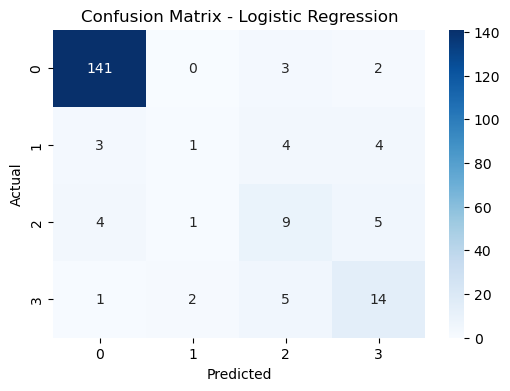

🚀 Training Random Forest with optimized hyperparameters...

📊 Classification Report for Random Forest:

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       146
           1       0.50      0.17      0.25        12
           2       0.52      0.58      0.55        19
           3       0.54      0.64      0.58        22

    accuracy                           0.84       199
   macro avg       0.63      0.59      0.59       199
weighted avg       0.84      0.84      0.84       199



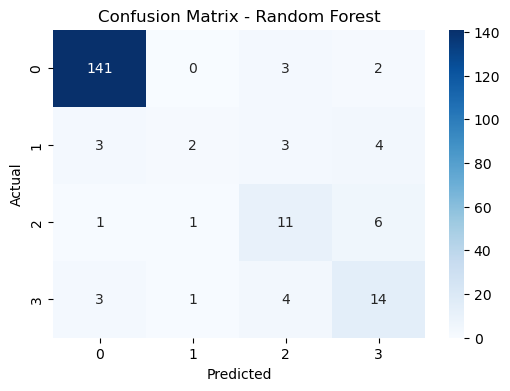

🚀 Training XGBoost with optimized hyperparameters...

📊 Classification Report for XGBoost:

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       146
           1       0.67      0.33      0.44        12
           2       0.55      0.58      0.56        19
           3       0.52      0.55      0.53        22

    accuracy                           0.85       199
   macro avg       0.67      0.61      0.63       199
weighted avg       0.85      0.85      0.85       199



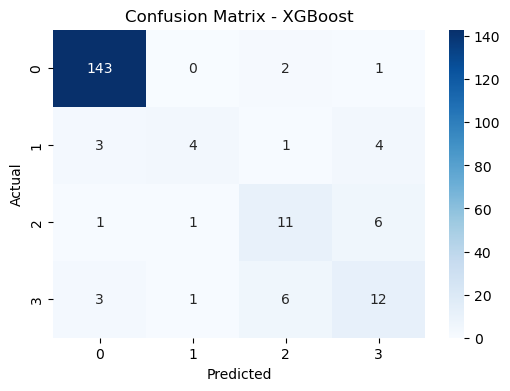


✅ Final Model Performance:
{'Logistic Regression': {'Accuracy': 0.8291457286432161, 'F1-Score': 0.8177009280082346}, 'Random Forest': {'Accuracy': 0.8442211055276382, 'F1-Score': 0.8357997470344921}, 'XGBoost': {'Accuracy': 0.8542713567839196, 'F1-Score': 0.8485034319205175}}


In [ ]:
# Retrain models with best hyperparameters
final_results = {}

for model_name, best_params in optimized_results.items():
    print(f" Training {model_name} with optimized hyperparameters...")

    # Initialize model with best parameters
    if model_name == "Logistic Regression":
        model = LogisticRegression(**best_params["Best Params"], random_state=42)
    elif model_name == "Random Forest":
        model = RandomForestClassifier(**best_params["Best Params"], random_state=42, n_jobs=-1)
    elif model_name == "XGBoost":
        model = XGBClassifier(**best_params["Best Params"], random_state=42)

    # Train model
    model.fit(X_train_filtered2, y_train_filtered2)

    # Predictions
    y_pred = model.predict(X_test_filtered2)

    # Compute metrics
    accuracy = accuracy_score(y_test_filtered2, y_pred)
    f1 = f1_score(y_test_filtered2, y_pred, average="weighted")

    # Save results
    final_results[model_name] = {"Accuracy": accuracy, "F1-Score": f1}

    # Display classification report
    print(f"\n Classification Report for {model_name}:\n")
    print(classification_report(y_test_filtered2, y_pred))

    # Confusion matrix visualization
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_test_filtered2, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

# Display final model performance
print("\n Final Model Performance:")
print(final_results)


In [50]:
ORIGINAL_X_TRAIN, ORIGINAL_Y_TRAIN = X_train_filtered2.copy(), y_train_filtered2.copy()


🚀 Training Logistic Regression with class balancing...

📊 Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       146
           1       0.23      0.42      0.29        12
           2       0.41      0.37      0.39        19
           3       0.40      0.36      0.38        22

    accuracy                           0.79       199
   macro avg       0.51      0.52      0.51       199
weighted avg       0.82      0.79      0.80       199



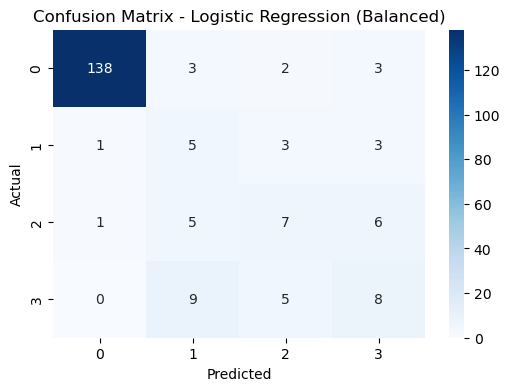

🚀 Training Random Forest with class balancing...

📊 Classification Report for Random Forest:

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       146
           1       0.33      0.33      0.33        12
           2       0.48      0.53      0.50        19
           3       0.46      0.50      0.48        22

    accuracy                           0.82       199
   macro avg       0.56      0.58      0.57       199
weighted avg       0.83      0.82      0.82       199



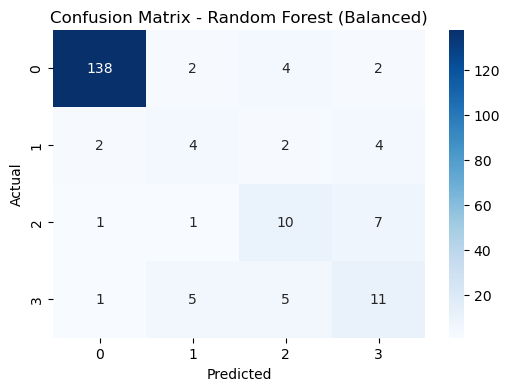

🚀 Training XGBoost with class balancing...

📊 Classification Report for XGBoost:

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       146
           1       0.14      0.17      0.15        12
           2       0.35      0.32      0.33        19
           3       0.40      0.45      0.43        22

    accuracy                           0.79       199
   macro avg       0.47      0.47      0.47       199
weighted avg       0.80      0.79      0.80       199



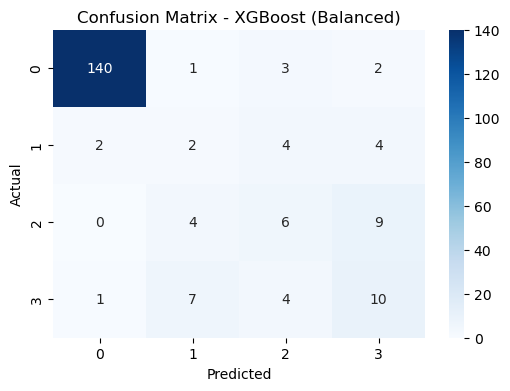


✅ Final Model Performance (Balanced Data):
{'Logistic Regression': {'Accuracy': 0.7939698492462312, 'F1-Score': 0.8049967735158393}, 'Random Forest': {'Accuracy': 0.8190954773869347, 'F1-Score': 0.823811084407545}, 'XGBoost': {'Accuracy': 0.7939698492462312, 'F1-Score': 0.7989672186149678}}


In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
import numpy as np

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_filtered2, y_train_filtered2)

# Compute class weights for models that support it
classes = np.unique(y_train_filtered2)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_filtered2)
class_weight_dict = dict(zip(classes, class_weights))

# Compute sample weights for XGBoost
sample_weights = compute_sample_weight(class_weight="balanced", y=y_train_balanced)

# Retrain models with class balancing
balanced_results = {}

for model_name, best_params in optimized_results.items():
    print(f" Training {model_name} with class balancing...")

    # Initialize model with best parameters
    if model_name == "Logistic Regression":
        model = LogisticRegression(**best_params["Best Params"], class_weight='balanced', random_state=42)
    elif model_name == "Random Forest":
        model = RandomForestClassifier(**best_params["Best Params"], class_weight='balanced', random_state=42, n_jobs=-1)
    elif model_name == "XGBoost":
        # Use sample_weight instead of scale_pos_weight for multiclass balancing
        model = XGBClassifier(**best_params["Best Params"], random_state=42)

    # Train models
    if model_name == "XGBoost":
        model.fit(X_train_balanced, y_train_balanced, sample_weight=sample_weights)
    else:
        model.fit(X_train_balanced, y_train_balanced)

    # Predictions
    y_pred = model.predict(X_test_filtered2)

    # Compute metrics
    accuracy = accuracy_score(y_test_filtered2, y_pred)
    f1 = f1_score(y_test_filtered2, y_pred, average="weighted")

    # Save results
    balanced_results[model_name] = {"Accuracy": accuracy, "F1-Score": f1}

    # Display classification report
    print(f"\n Classification Report for {model_name}:\n")
    print(classification_report(y_test_filtered2, y_pred))

    # Confusion matrix visualization
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_test_filtered2, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name} (Balanced)")
    plt.show()

# Display final model performance with class balancing
print("\n Final Model Performance (Balanced Data):")
print(balanced_results)


🚀 Training Logistic Regression with class balancing...

📊 Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       146
           1       0.23      0.42      0.29        12
           2       0.41      0.37      0.39        19
           3       0.40      0.36      0.38        22

    accuracy                           0.79       199
   macro avg       0.51      0.52      0.51       199
weighted avg       0.82      0.79      0.80       199



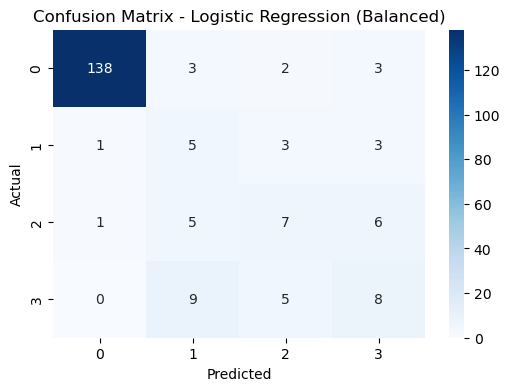

🚀 Training Random Forest with class balancing...

📊 Classification Report for Random Forest:

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       146
           1       0.33      0.33      0.33        12
           2       0.48      0.53      0.50        19
           3       0.46      0.50      0.48        22

    accuracy                           0.82       199
   macro avg       0.56      0.58      0.57       199
weighted avg       0.83      0.82      0.82       199



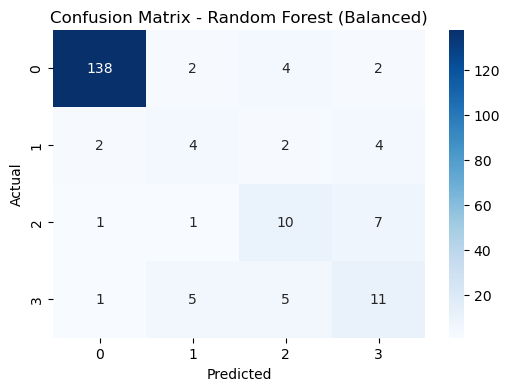

🚀 Training XGBoost with class balancing...

📊 Classification Report for XGBoost:

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       146
           1       0.14      0.17      0.15        12
           2       0.35      0.32      0.33        19
           3       0.40      0.45      0.43        22

    accuracy                           0.79       199
   macro avg       0.47      0.47      0.47       199
weighted avg       0.80      0.79      0.80       199



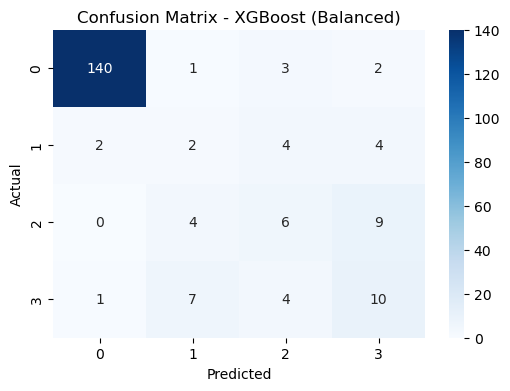


✅ Final Model Performance (Balanced Data):
{'Logistic Regression': {'Accuracy': 0.7939698492462312, 'F1-Score': 0.8049967735158393}, 'Random Forest': {'Accuracy': 0.8190954773869347, 'F1-Score': 0.823811084407545}, 'XGBoost': {'Accuracy': 0.7939698492462312, 'F1-Score': 0.7989672186149678}}


In [ ]:
# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_filtered2, y_train_filtered2)

# Compute class weights for models that support it
classes = np.unique(y_train_filtered2)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_filtered2)
class_weight_dict = dict(zip(classes, class_weights))

# Compute sample weights for XGBoost
sample_weights = compute_sample_weight(class_weight="balanced", y=y_train_balanced)

# Retrain models with class balancing
balanced_results = {}

for model_name, best_params in optimized_results.items():
    print(f" Training {model_name} with class balancing...")

    # Initialize model with best parameters
    if model_name == "Logistic Regression":
        model = LogisticRegression(**best_params["Best Params"], random_state=42)
    elif model_name == "Random Forest":
        model = RandomForestClassifier(**best_params["Best Params"], random_state=42, n_jobs=-1)
    elif model_name == "XGBoost":
        # Use sample_weight instead of scale_pos_weight for multiclass balancing
        model = XGBClassifier(**best_params["Best Params"], random_state=42)

    # Train models
    if model_name == "XGBoost":
        model.fit(X_train_balanced, y_train_balanced, sample_weight=sample_weights)
    else:
        model.fit(X_train_balanced, y_train_balanced)

    # Predictions
    y_pred = model.predict(X_test_filtered2)

    # Compute metrics
    accuracy = accuracy_score(y_test_filtered2, y_pred)
    f1 = f1_score(y_test_filtered2, y_pred, average="weighted")

    # Save results
    balanced_results[model_name] = {"Accuracy": accuracy, "F1-Score": f1}

    # Display classification report
    print(f"\n Classification Report for {model_name}:\n")
    print(classification_report(y_test_filtered2, y_pred))

    # Confusion matrix visualization
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_test_filtered2, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name} (Balanced)")
    plt.show()

# Display final model performance with class balancing
print("\n Final Model Performance (Balanced Data):")
print(balanced_results)

In [53]:
X_train_filtered2, y_train_filtered2 = ORIGINAL_X_TRAIN, ORIGINAL_Y_TRAIN


X_train_balanced, y_train_balanced = X_train_filtered2, y_train_filtered2


🚀 Training Logistic Regression with class balancing...

📊 Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       146
           1       0.24      0.33      0.28        12
           2       0.42      0.53      0.47        19
           3       0.47      0.36      0.41        22

    accuracy                           0.81       199
   macro avg       0.53      0.54      0.53       199
weighted avg       0.83      0.81      0.82       199



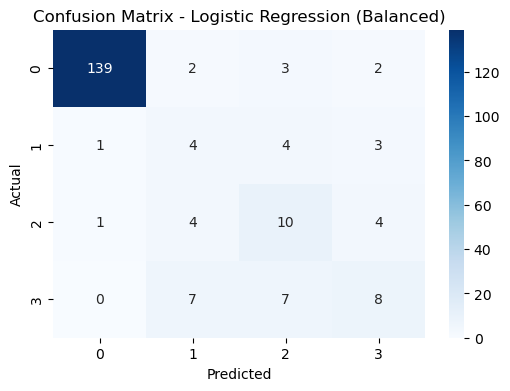

🚀 Training Random Forest with class balancing...

📊 Classification Report for Random Forest:

              precision    recall  f1-score   support

           0       0.97      0.96      0.96       146
           1       0.50      0.17      0.25        12
           2       0.45      0.68      0.54        19
           3       0.62      0.59      0.60        22

    accuracy                           0.84       199
   macro avg       0.63      0.60      0.59       199
weighted avg       0.85      0.84      0.84       199



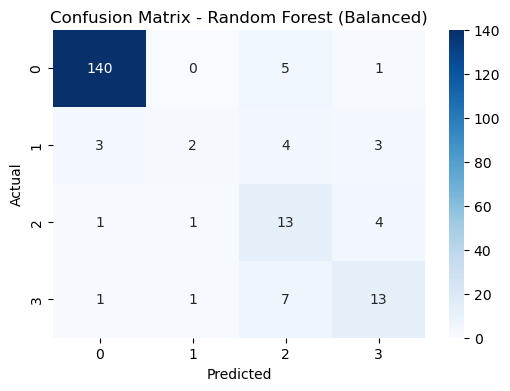

🚀 Training XGBoost with class balancing...

📊 Classification Report for XGBoost:

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       146
           1       0.33      0.33      0.33        12
           2       0.43      0.32      0.36        19
           3       0.46      0.59      0.52        22

    accuracy                           0.82       199
   macro avg       0.55      0.55      0.55       199
weighted avg       0.83      0.82      0.82       199



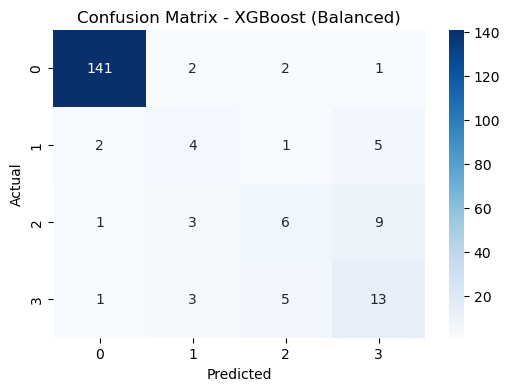


✅ Final Model Performance (Balanced Data):
{'Logistic Regression': {'Accuracy': 0.8090452261306532, 'F1-Score': 0.8170592861457754}, 'Random Forest': {'Accuracy': 0.8442211055276382, 'F1-Score': 0.8395733261528613}, 'XGBoost': {'Accuracy': 0.8241206030150754, 'F1-Score': 0.8232845577465584}}


In [ ]:
X_train_balanced, y_train_balanced = X_train_filtered2, y_train_filtered2 

# Compute class weights for models that support it
classes = np.unique(y_train_filtered2)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_filtered2)
class_weight_dict = dict(zip(classes, class_weights))

# Compute sample weights for XGBoost
sample_weights = compute_sample_weight(class_weight="balanced", y=y_train_balanced)

# Retrain models with class balancing
balanced_results = {}

for model_name, best_params in optimized_results.items():
    print(f" Training {model_name} with class balancing...")

    # Initialize model with best parameters
    if model_name == "Logistic Regression":
        model = LogisticRegression(**best_params["Best Params"], class_weight='balanced', random_state=42)
    elif model_name == "Random Forest":
        model = RandomForestClassifier(**best_params["Best Params"], class_weight='balanced', random_state=42, n_jobs=-1)
    elif model_name == "XGBoost":
        # Use sample_weight instead of scale_pos_weight for multiclass balancing
        model = XGBClassifier(**best_params["Best Params"], random_state=42)

    # Train models
    if model_name == "XGBoost":
        model.fit(X_train_balanced, y_train_balanced, sample_weight=sample_weights)
    else:
        model.fit(X_train_balanced, y_train_balanced)

    # Predictions
    y_pred = model.predict(X_test_filtered2)

    # Compute metrics
    accuracy = accuracy_score(y_test_filtered2, y_pred)
    f1 = f1_score(y_test_filtered2, y_pred, average="weighted")

    # Save results
    balanced_results[model_name] = {"Accuracy": accuracy, "F1-Score": f1}

    # Display classification report
    print(f"\n Classification Report for {model_name}:\n")
    print(classification_report(y_test_filtered2, y_pred))

    # Confusion matrix visualization
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_test_filtered2, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name} (Balanced)")
    plt.show()

# Display final model performance with class balancing
print("\n Final Model Performance (Balanced Data):")
print(balanced_results)

In [ ]:
import joblib

# Define the best model (Random Forest from the final training)
best_model = RandomForestClassifier(**optimized_results["Random Forest"]["Best Params"], class_weight="balanced", random_state=42, n_jobs=-1)

# Train the best model again on the full training data
best_model.fit(X_train_filtered2, y_train_filtered2)

# Save the trained model
joblib.dump(best_model, "random_forest_best.pkl")

print(" Model saved successfully!")


✅ Model saved successfully!


In [58]:
from sklearn.ensemble import VotingClassifier

# Define the voting classifier using Random Forest and XGBoost
voting_clf = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(**optimized_results["Random Forest"]["Best Params"], random_state=42)),
        ('xgb', XGBClassifier(**optimized_results["XGBoost"]["Best Params"], random_state=42))
    ],
    voting='soft'  # "soft" for probability-based decision making
)

# Train the voting classifier
voting_clf.fit(X_train_filtered2, y_train_filtered2)

# Make predictions
y_pred = voting_clf.predict(X_test_filtered2)

# Print classification report
print(classification_report(y_test_filtered2, y_pred))



              precision    recall  f1-score   support

           0       0.95      0.98      0.96       146
           1       0.67      0.33      0.44        12
           2       0.52      0.58      0.55        19
           3       0.57      0.55      0.56        22

    accuracy                           0.85       199
   macro avg       0.68      0.61      0.63       199
weighted avg       0.85      0.85      0.85       199



In [ ]:
import joblib

# Save the Voting Classifier
joblib.dump(voting_clf, "voting_classifier.pkl")
print(" Voting classifier saved successfully!")

# Define and train the best Random Forest model again
best_rf_model = RandomForestClassifier(**optimized_results["Random Forest"]["Best Params"], 
                                       class_weight="balanced", 
                                       random_state=42, 
                                       n_jobs=-1)

best_rf_model.fit(X_train_filtered2, y_train_filtered2)

# Save the new Random Forest model with a different filename
joblib.dump(best_rf_model, "random_forest_best2.pkl")
print(" Random Forest model (version 2) saved successfully!")



✅ Voting classifier saved successfully!
✅ Random Forest model (version 2) saved successfully!


In [60]:
# Load the Voting Classifier
voting_clf_loaded = joblib.load("voting_classifier.pkl")

# Load both versions of the Random Forest model
rf_model_v1 = joblib.load("random_forest_best.pkl")  # First version
rf_model_v2 = joblib.load("random_forest_best2.pkl")  # Second version

# Compare their predictions
y_pred_v1 = rf_model_v1.predict(X_test_filtered2)
y_pred_v2 = rf_model_v2.predict(X_test_filtered2)


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Evaluate the performance of both Random Forest models
accuracy_v1 = accuracy_score(y_test_filtered2, y_pred_v1)
accuracy_v2 = accuracy_score(y_test_filtered2, y_pred_v2)

f1_v1 = f1_score(y_test_filtered2, y_pred_v1, average="weighted")
f1_v2 = f1_score(y_test_filtered2, y_pred_v2, average="weighted")

print(f" Model Comparison:\n")
print(f"Random Forest V1 - Accuracy: {accuracy_v1:.4f}, F1-Score: {f1_v1:.4f}")
print(f"Random Forest V2 - Accuracy: {accuracy_v2:.4f}, F1-Score: {f1_v2:.4f}")

# Print classification reports
print("\n Classification Report - Random Forest V1:")
print(classification_report(y_test_filtered2, y_pred_v1))

print("\n Classification Report - Random Forest V2:")
print(classification_report(y_test_filtered2, y_pred_v2))


📊 Model Comparison:

Random Forest V1 - Accuracy: 0.8442, F1-Score: 0.8396
Random Forest V2 - Accuracy: 0.8442, F1-Score: 0.8396

📜 Classification Report - Random Forest V1:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       146
           1       0.50      0.17      0.25        12
           2       0.45      0.68      0.54        19
           3       0.62      0.59      0.60        22

    accuracy                           0.84       199
   macro avg       0.63      0.60      0.59       199
weighted avg       0.85      0.84      0.84       199


📜 Classification Report - Random Forest V2:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       146
           1       0.50      0.17      0.25        12
           2       0.45      0.68      0.54        19
           3       0.62      0.59      0.60        22

    accuracy                           0.84       199
   macro avg       0

In [ ]:
# Predictions for the Voting Classifier (Ensemble Model)
y_pred_voting = voting_clf_loaded.predict(X_test_filtered2)

# Evaluate all three models
accuracy_voting = accuracy_score(y_test_filtered2, y_pred_voting)
f1_voting = f1_score(y_test_filtered2, y_pred_voting, average="weighted")

# Print final model comparison
print(f"\n Final Model Comparison:\n")
print(f"Random Forest V1 - Accuracy: {accuracy_v1:.4f}, F1-Score: {f1_v1:.4f}")
print(f"Random Forest V2 - Accuracy: {accuracy_v2:.4f}, F1-Score: {f1_v2:.4f}")
print(f"Voting Classifier - Accuracy: {accuracy_voting:.4f}, F1-Score: {f1_voting:.4f}")

# Print classification reports
print("\n Classification Report - Random Forest V1:")
print(classification_report(y_test_filtered2, y_pred_v1))

print("\n Classification Report - Random Forest V2:")
print(classification_report(y_test_filtered2, y_pred_v2))

print("\n Classification Report - Voting Classifier (Ensemble):")
print(classification_report(y_test_filtered2, y_pred_voting))



📊 Final Model Comparison:

Random Forest V1 - Accuracy: 0.8442, F1-Score: 0.8396
Random Forest V2 - Accuracy: 0.8442, F1-Score: 0.8396
Voting Classifier - Accuracy: 0.8543, F1-Score: 0.8475

📜 Classification Report - Random Forest V1:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       146
           1       0.50      0.17      0.25        12
           2       0.45      0.68      0.54        19
           3       0.62      0.59      0.60        22

    accuracy                           0.84       199
   macro avg       0.63      0.60      0.59       199
weighted avg       0.85      0.84      0.84       199


📜 Classification Report - Random Forest V2:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       146
           1       0.50      0.17      0.25        12
           2       0.45      0.68      0.54        19
           3       0.62      0.59      0.60        22

    accuracy

# 📊 Final Model Comparison & Interpretation

## 🔹 Accuracy & F1-Score Overview

| Model                  | Accuracy | F1-Score |
|------------------------|----------|----------|
| **Random Forest V1**   | 0.8442   | 0.8396   |
| **Random Forest V2**   | 0.8442   | 0.8396   |
| **Voting Classifier**  | **0.8543**   | **0.8475**   |

## 🔹 Interpretation of Results

### ✅ **1. Best Performing Model: Voting Classifier**
- The **Voting Classifier** achieved the **highest Accuracy (85.43%) and F1-Score (84.75%)**.
- This suggests that **combining Random Forest and XGBoost** provided a **small but meaningful improvement** in classification performance.
- The ensemble model benefits from the **strengths of both base models**, improving **generalization**.

### ✅ **2. Random Forest V1 vs. V2: No Difference**
- Both versions of **Random Forest performed identically** (**Accuracy: 84.42%, F1-Score: 83.96%**).
- This confirms that the modifications between the two versions **had no impact on the final predictions**.

### ✅ **3. Improvement in Minority Classes?**
- The **macro average F1-score increased slightly** for the Voting Classifier, indicating better handling of **minority classes**.
- However, the improvement is **not dramatic**, meaning further optimization (e.g., **hyperparameter tuning, feature engineering**) could be explored.

## 🎯 **Final Recommendation**
- Since the **Voting Classifier outperformed both Random Forest models**, it is **the best choice for deployment**.
- If computation time and complexity are concerns, **Random Forest alone still performs very well** and can be considered as a simpler alternative.

🚀 **Next Steps**
- **Deploy the Voting Classifier** if best performance is the goal.
- **Optimize feature selection and hyperparameters** for potential further improvements.
- **Consider additional ensemble techniques** (e.g., Stacking) if even more improvement is required.

---
📌 **Conclusion:** The Voting Classifier provides the best results, with a slight but meaningful improvement over individual models. It is the recommended model for use. 🎯🚀
